# Arbres Fractales - Complexité

### Mastère spécialisé IA - Télécom Paris

### IA703 - Algorithmic Information and AI -  Jean-Louis Dessalles

#### Luca Hachani - Robin Guiavarch


## Sommaire

1. **Arbres fractales - Encodage naïf et brutal**
   * 1.1. Arbre Mandelbrot/Vicsek
   * 1.2. Arbre de Galton Watson

2. **Arbres fractales - Encodage via marche de Harris**
   * 2.1. Arbre Mandelbrot/Vicsek
   * 2.2. Arbre de Galton Watson

3. **Compresseur - Mise en place**
   * 3.1. Compresseur maison
   * 3.2. Compresseurs classiques : zip, gzip, bzip2

4. **Compression des marches de Harris binaires**
   * 4.1. Arbre Mandelbrot/Vicsek
   * 4.2. Arbre de Galton Watson

5. **Clustering via distance NCD**
   * 5.1. Sur fractale immature
      * 5.1.1. Arbre Mandelbrot/Vicsek (*paramètre m*)
      * 5.1.2. Arbre de Galton Watson (*paramètre p*, loi géométrique)
   * 5.2. Sur fractale mature
      * 5.2.1. Arbre Mandelbrot/Vicsek (*paramètre m de construction*)
      * 5.2.2. Arbre de Galton Watson (*paramètre p*, loi géométrique)

In [2]:
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [12]:
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
from math import log2, ceil
import zlib
import gzip
import io
import bz2
import pandas as pd
import seaborn as sns

In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz


### 1. **Arbres fractales - Encodage naïf et brutal**


#### 1.1. Arbre Mandelbrot/Vicsek

In [2]:
from collections import deque

class Node:
    def __init__(self, value):
        self.value = value
        self.children = []

class FractalTree:
    def __init__(self):
        self.edges = []  # Liste des arêtes (vi, vj)
        self.next_node_id = 0

    def add_edge(self, vi, vj):
        self.edges.append((vi, vj))

    def initialize_tree(self):
        # Arbre initial : une arête (0 -> 1)
        self.add_edge(self.next_node_id, self.next_node_id + 1)
        self.next_node_id += 2

    def iterate(self):
        new_edges = []
        for vi, vj in self.edges:
            # Créer deux nouveaux nœuds
            va = self.next_node_id
            vb = self.next_node_id + 1
            # Remplacer l'arête existante par trois nouvelles arêtes
            # (vi, va), (vj, va), (va, vb)
            new_edges.append((vi, va))
            new_edges.append((vj, va))
            new_edges.append((va, vb))

            self.next_node_id += 2
        self.edges = new_edges

    def build_tree(self, iterations):
        self.initialize_tree()
        for _ in range(iterations):
            self.iterate()

    def assign_depth_values(self, root=0):
        """
        Réalise un BFS à partir de la racine pour déterminer la profondeur de chaque nœud.
        Renvoie un dictionnaire {node_id: profondeur}.
        """
        adj = {}
        for (vi, vj) in self.edges:
            adj.setdefault(vi, []).append(vj)
            adj.setdefault(vj, []).append(vi)

        depth = {root: 0}
        queue = deque([root])
        while queue:
            u = queue.popleft()
            for w in adj.get(u, []):
                if w not in depth:
                    depth[w] = depth[u] + 1
                    queue.append(w)
        return depth

    def build_node_structure(self, root=0):
        """
        Construit la structure de nœuds (instances de Node) à partir des arêtes.
        Les valeurs des nœuds correspondent à leur profondeur (calculée par assign_depth_values).
        """
        depth = self.assign_depth_values(root)
        # Construisons un adjacence orientée dans le sens parent->enfant
        # Un enfant est un nœud w tel que depth[w] = depth[u] + 1
        adj = {}
        for (vi, vj) in self.edges:
            # On ajoute dans les deux sens pour faciliter la recherche
            adj.setdefault(vi, []).append(vj)
            adj.setdefault(vj, []).append(vi)

        visited = set()

        def build_subtree(u):
            visited.add(u)
            node = Node(depth[u])
            # Les enfants sont ceux dont la profondeur est depth[u] + 1
            for w in adj.get(u, []):
                if w not in visited and depth.get(w, -1) == depth[u] + 1:
                    node.children.append(build_subtree(w))
            return node

        return build_subtree(root)

def print_node_tree(node, level=0):
    print("  " * level + f"Node({node.value})")
    for child in node.children:
        print_node_tree(child, level + 2)

In [3]:
# Instanciation
fractal_tree = FractalTree()

# Nombre d'itérations
iterations = 3

# Construction
fractal_tree.build_tree(iterations)
root_node = fractal_tree.build_node_structure(root=0)
print_node_tree(root_node)

Node(0)
    Node(1)
        Node(2)
            Node(3)
                Node(4)
                    Node(5)
                        Node(6)
                            Node(7)
                                Node(8)
                                Node(8)
                            Node(7)
                                Node(8)
                                Node(8)
                        Node(6)
                    Node(5)
                        Node(6)
                            Node(7)
                                Node(8)
                                Node(8)
                            Node(7)
                                Node(8)
                                Node(8)
                        Node(6)
                Node(4)
            Node(3)
                Node(4)
                Node(4)
        Node(2)


#### 1.2 Arbre de Galton-Watson

In [4]:
import random

class Node:
    def __init__(self, value):
        self.value = value
        self.children = []

    def __repr__(self):
        return f"Node({self.value})"


def geometric_random(p=0.5):
    """
    Génère un entier k ≥ 0 selon une loi géométrique de paramètre p, avec :
    P(X = k) = (1 - p)^k * p.
    """
    count = 0
    while random.random() >= p:
        count += 1
    return count


def build_galton_watson_tree(max_depth=100, current_depth=0, p=0.5):
    """
    Construit un arbre de Galton-Watson avec un nombre d'enfants distribué
    géométriquement (paramètre p).
    """
    node = Node(current_depth)
    if current_depth < max_depth:
        num_children = geometric_random(p)
        for _ in range(num_children):
            child = build_galton_watson_tree(max_depth, current_depth + 1, p)
            node.children.append(child)
    return node


def print_node_tree(node, level=0):
    """
    Affiche l'arbre avec une indentation reflétant la structure hiérarchique.
    """
    print("  " * level + f"Node({node.value})")
    for child in node.children:
        print_node_tree(child, level + 2)

In [ ]:
# Paramètres pour l'arbre de Galton-Watson
max_depth = 4
p = 0.3

# Construire et afficher l'arbre
root = build_galton_watson_tree(max_depth=max_depth, p=p)
print_node_tree(root)

Node(0)
    Node(1)
        Node(2)
            Node(3)
                Node(4)
                Node(4)
                Node(4)
                Node(4)
                Node(4)
            Node(3)
                Node(4)
                Node(4)
                Node(4)
                Node(4)
            Node(3)
                Node(4)
                Node(4)
                Node(4)
                Node(4)
                Node(4)
                Node(4)
        Node(2)
            Node(3)
                Node(4)
                Node(4)
            Node(3)
                Node(4)
            Node(3)
                Node(4)
                Node(4)
                Node(4)
                Node(4)
        Node(2)
            Node(3)
                Node(4)
        Node(2)
            Node(3)
    Node(1)


### 2. **Arbres fractales - Encodage via marche de Harris**


#### 2.0. Fonctions utilisées (pour visualisation, etc)

In [28]:
def tree_build_from_harris_walk(walk):
    """
    Génère et affiche un arbre optimisé autour de sa racine,
    basé sur une marche de Harris.

    Args:
        walk (list or numpy.ndarray): La marche de Harris à partir de laquelle
                                      construire l'arbre.

    Returns:
        None: Affiche l'arbre généré.
    """
    # Initialisation de l'arbre
    arbre = nx.DiGraph()  # Graphe orienté pour représenter l'arbre

    # Ajout du nœud racine
    root = 0
    arbre.add_node(root)

    # Construction de l'arbre en suivant la marche de Harris
    parent = root
    for i in range(1, len(walk)):
        if walk[i] > walk[i - 1]:
            # Ajout d'un nouveau fils
            arbre.add_edge(parent, i)
            parent = i
        elif walk[i] < walk[i - 1]:
            # Retour au parent précédent
            parent = list(arbre.predecessors(parent))[0]

    return arbre, root

In [29]:
def visualisation_tree(arbre, root=None):
    """
    Génère et affiche un arbre optimisé autour de sa racine,
    basé sur une marche de Harris.

    Args:
        walk (list or numpy.ndarray): La marche de Harris à partir de laquelle
                                      construire l'arbre.

    Returns:
        None: Affiche l'arbre généré.
    """

    # Visualisation : centrée autour de la racine
    if root!=None :
        pos = nx.drawing.nx_agraph.graphviz_layout(arbre, prog="twopi", root=root)
    else :
        pos = nx.nx_agraph.graphviz_layout(arbre, prog="dot")  # Disposition en arbre

    # Taille et style de la figure
    plt.figure(figsize=(12, 12))  # Taille équilibrée pour la disposition radiale
    nx.draw(
        arbre,
        pos,
        with_labels=True,
        arrows=False,
        node_size=800,
        node_color="lightblue",
        font_size=10,
        edge_color="gray",
    )
    plt.title("Arbre Centré sur la Racine (Marche de Harris)", fontsize=16)
    plt.show()


In [30]:
def visualisation_harris_walk(S, N=None, m=None, offset=0):
    # Définir les intervalles et leurs couleurs associées
    intervals = [
        (0+offset, 1+offset, "blue"),    # Intervalle [0, 10) avec la couleur bleue
        (1+offset, 2+offset, "green"),  # Intervalle [10, 20) avec la couleur verte
        (2+offset, 4+offset, "red"),    # Intervalle [20, 30) avec la couleur rouge
        (4+offset, 8+offset, "orange"), # Intervalle [30, 40) avec la couleur orange
        (8+offset, float("inf"), "purple")  # Intervalle [40, +inf) avec la couleur violette
    ]

    # Fonction pour trouver la couleur en fonction de la valeur
    def get_color(value):
        for low, high, color in intervals:
            if low <= value < high:
                return color
        return "black"  # Couleur par défaut (si aucune condition n'est remplie)

    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(12, 6))  # Taille de la figure

    # Tracé des segments avec les couleurs associées
    for i in range(len(S) - 1):
        # Déterminer l'alpha en fonction de la valeur de x
        if m!=None:
            alpha = 1 if i < int((len(S)-1)/m) else 0.3
        else:
            alpha = 1
        ax.plot(
            [i, i+1], [S[i], S[i+1]],
            color=get_color(np.amin(S[i:i+2])),  # Couleur basée sur la valeur de S[i]
            alpha=alpha,
            marker="o"
        )

    if N!=None:
        x_max = (2*m**(N))*m
        y_max=2**N
    else:
        x_max = 0
        y_max = 0

    if m!=None :
        # Ajouter une double flèche indiquant l'intervalle sur les abscisses
        x_start, x_end = 0, (len(S)-1)/m
        y_arrow = min(S)  # Position verticale de la flèche, en dessous des points

        # Dessiner une flèche à double tête
        ax.annotate(
            '',  # Texte vide
            xy=(x_end, y_arrow), xytext=(x_start, y_arrow),
            arrowprops=dict(arrowstyle='<->', linewidth=2, color='black')
        )

        # Ajouter du texte pour indiquer l'intervalle
        ax.text((x_start + x_end) / 2, y_arrow-0.3, f"2*m**N = {x_end-x_start}",
                ha='center', va='center', fontsize=10, color='black')

    # Ajouter des titres et des labels
    ax.set_title("Marche de Harris")
    ax.set_xlim(0,np.maximum(len(S), x_max))
    ax.set_ylim(0,np.maximum(np.amax(S), y_max))
    if N!=None:
        ax.set_yticks(2**np.arange(N))
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlabel("pas")
    ax.set_ylabel("Génération")

    # adjust_figure_to_limits(ax, [0,len(S)],[0, np.amax(S)], scale=1)

    plt.show()


#### 2.1. Arbre Mandelbrot/Vicsek

In [8]:
def transformation_harris_walk(n, m, S_prev, verbose=False):
    """
    Effectue une transformation sur une séquence donnée pour générer une nouvelle séquence
    suivant une méthode inspirée de Harris Walk.

    Cette transformation applique une série d'opérations basées sur le pas `n`,
    une séquence précédente `S_prev`, et des manipulations utilisant des indices
    et des décalages.

    Args:
        n (int): Étape actuelle du processus.
        S_prev (numpy.ndarray): Séquence précédente utilisée comme base pour la transformation.
        verbose (bool, optional): Si True, affiche des informations détaillées
            sur les calculs effectués à chaque étape. Par défaut False.

    Returns:
        numpy.ndarray: Une nouvelle séquence générée après transformation.
    """
    # Calcul de la longueur du motif à extraire de la séquence précédente
    len_patern = int((1 / m) * (len(S_prev) - 1))

    # Calcul de la longueur du motif additionnel
    len_add_patern = (m - 1) * len_patern + 1

    # Définition d'un décalage dépendant de l'étape n
    offset = 2 ** (n - 1)

    if verbose:
        # Affichage des informations détaillées si verbose est activé
        print(f"---------- step = {n} ----------")
        print('len_patern =', len_patern)
        print('len_add_patern =', len_add_patern)
        print('offset =', offset)
        print('previous patern =', S_prev[:len_patern])
        print('previous patern set for addition =', np.delete(S_prev[:len_patern], offset))
        print('partern to add  =', S_prev[:len_add_patern] + offset)

    # Création de la nouvelle séquence
    S_next = np.insert(np.delete(S_prev[:len_patern], offset),
                       offset,
                       S_prev[:len_add_patern] + offset)

    # Répéter S_next m fois, puis ajouter [0]
    S_next = np.concatenate([np.tile(S_next, m), [0]])


    return S_next

In [9]:
def recurrence_transformation(N, m=3, verbose=False):
    S_prev = np.concatenate([np.tile([0, 1], m), [0]])
    print("motif de base:", S_prev)
    if N>0:
        for n in range(N):
            S_next = transformation_harris_walk(n+1, m, S_prev, verbose=verbose)
            S_prev = S_next
    else :
        S_next = S_prev
    return S_next

#### **Applications**

A l'aide de nos fonctions, nous pouvons visualiser 2 phénomènes:
* Comment un arbre fractale Mandelbrot/Vicsek se construit? Ceci nous a permis d'écrire un pseudo-code court.
* Quelle est l'influence du paramètre m (nombre de branches sortant du noeud racine de l'arbre) sur la construction de l'arbre? Dans la partie 5. nous faisons du clustering d'arbres fractales Mandelbrot/Vicsek en faisant varier ce paramètre.

motif de base: [0 1 0 1 0 1 0]


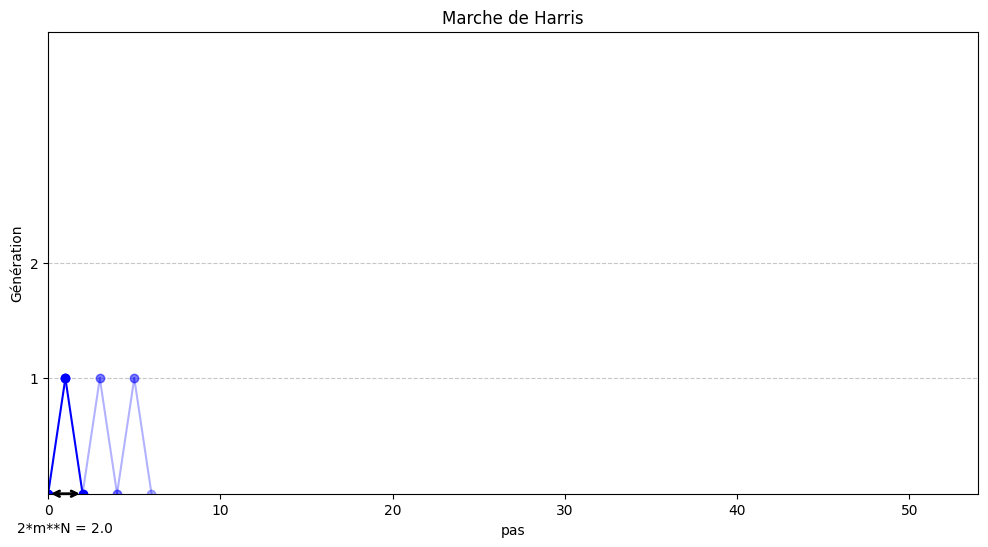

motif de base: [0 1 0 1 0 1 0]


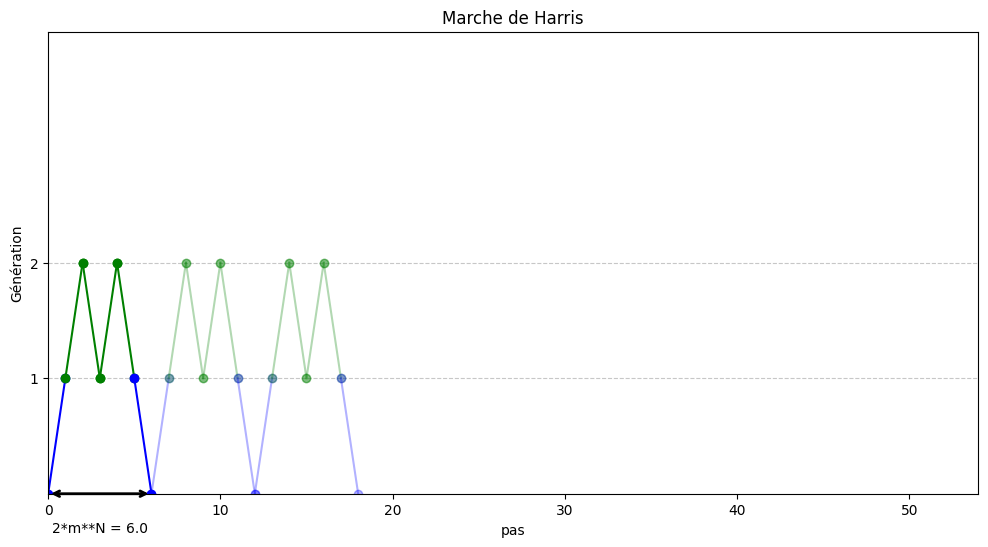

motif de base: [0 1 0 1 0 1 0]


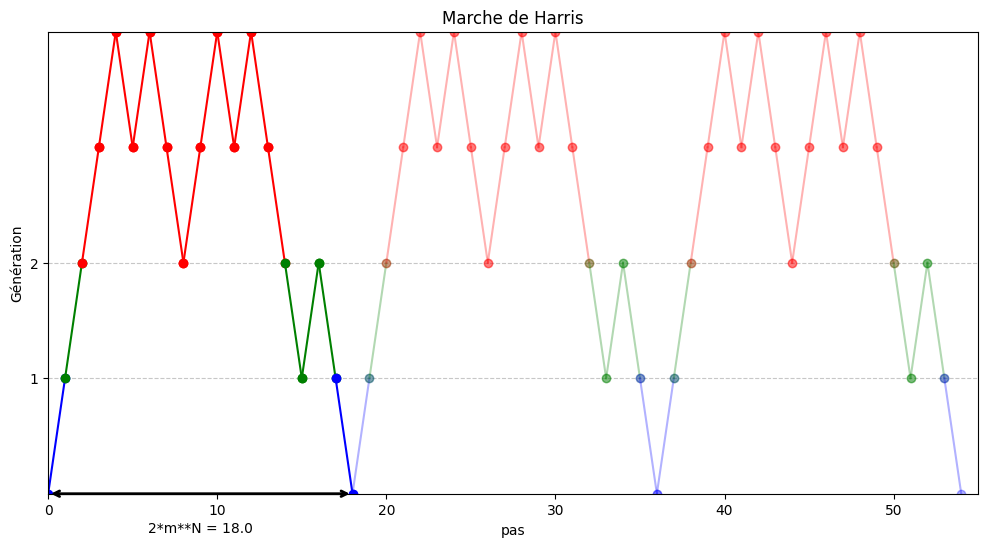

In [9]:
# Comment un arbre fractale Mandelbrot/Vicsek se construit? (selon sa marche de Harris)

m=3
N=2
for n in range(N+1):
    S = recurrence_transformation(n, m, verbose=False)
    visualisation_harris_walk(S, N=N, m=m)

Pour m=3
motif de base: [0 1 0 1 0 1 0]


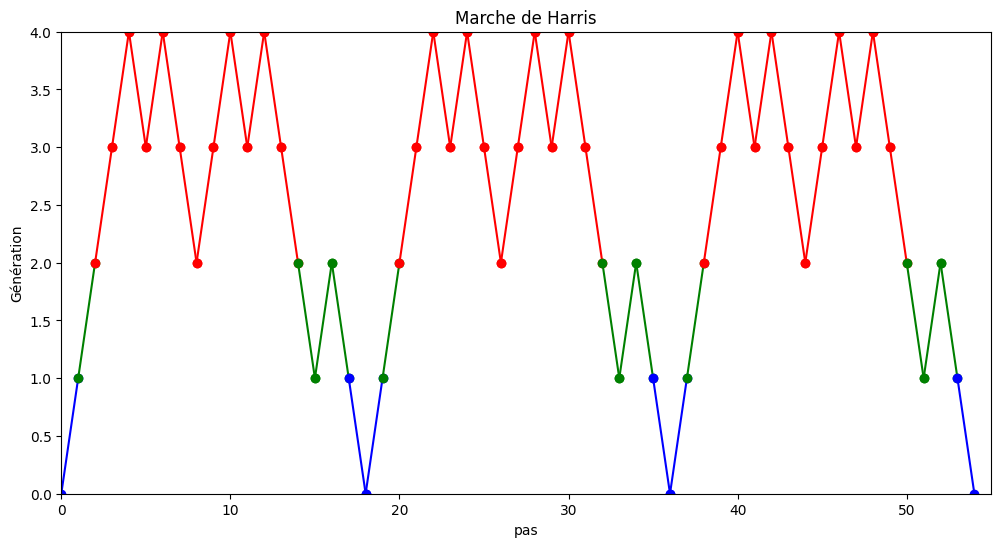

DiGraph with 28 nodes and 27 edges


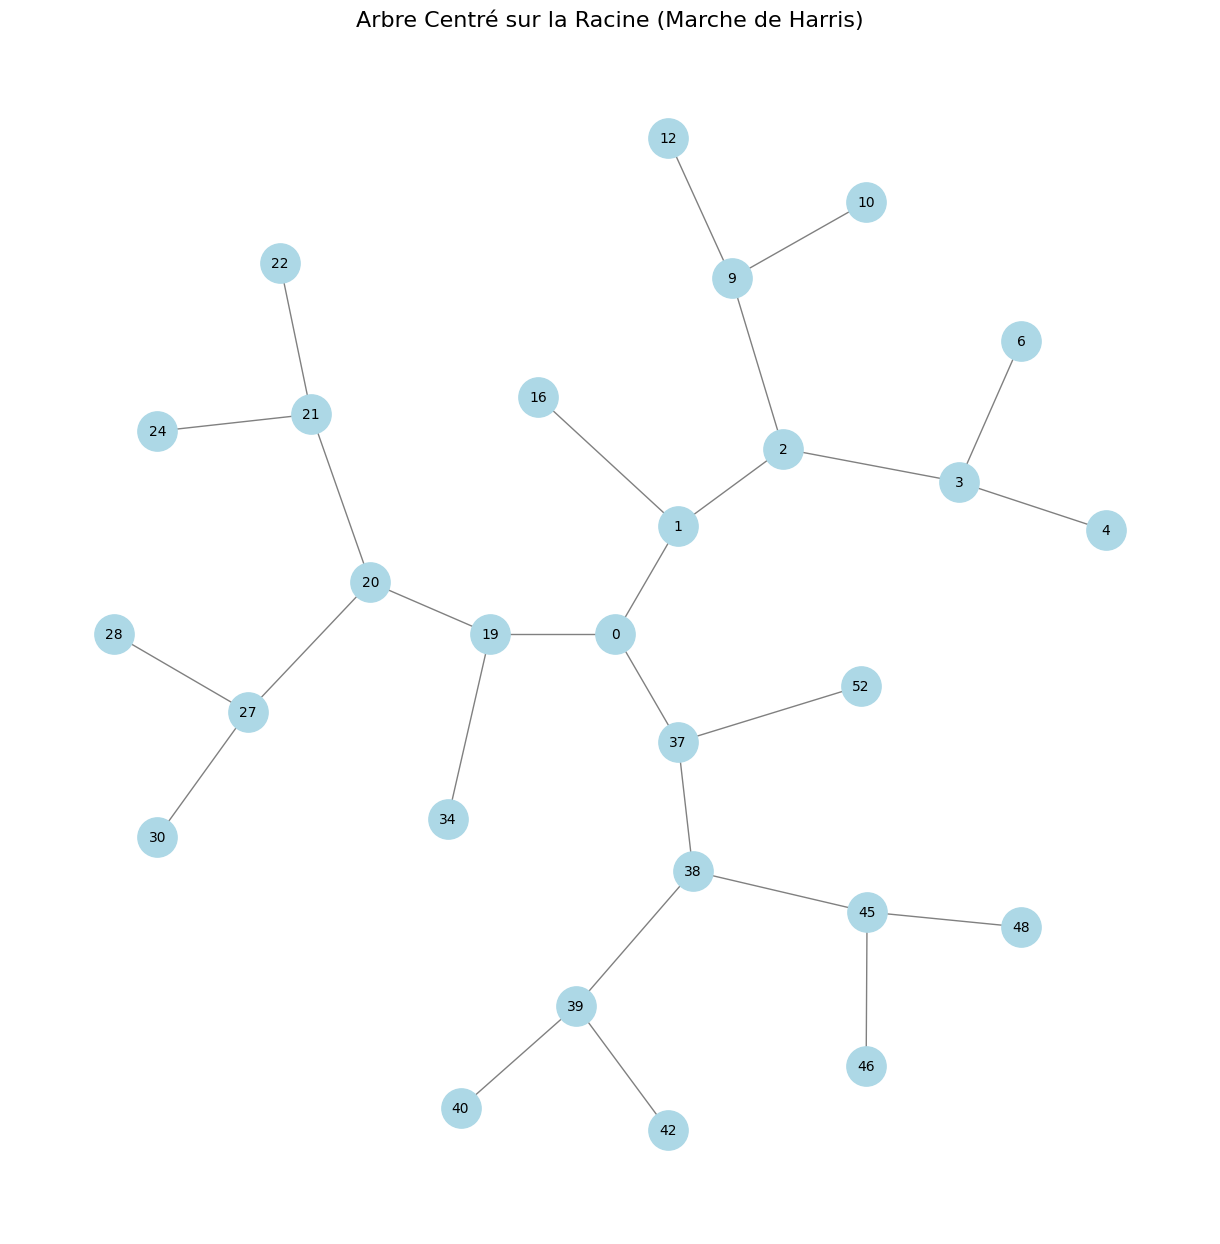

Pour m=4
motif de base: [0 1 0 1 0 1 0 1 0]


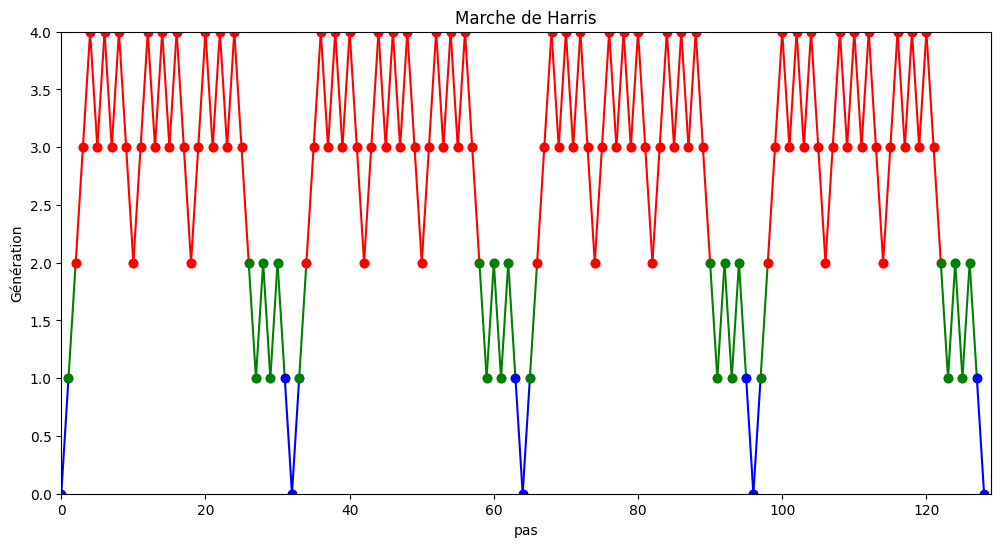

DiGraph with 65 nodes and 64 edges


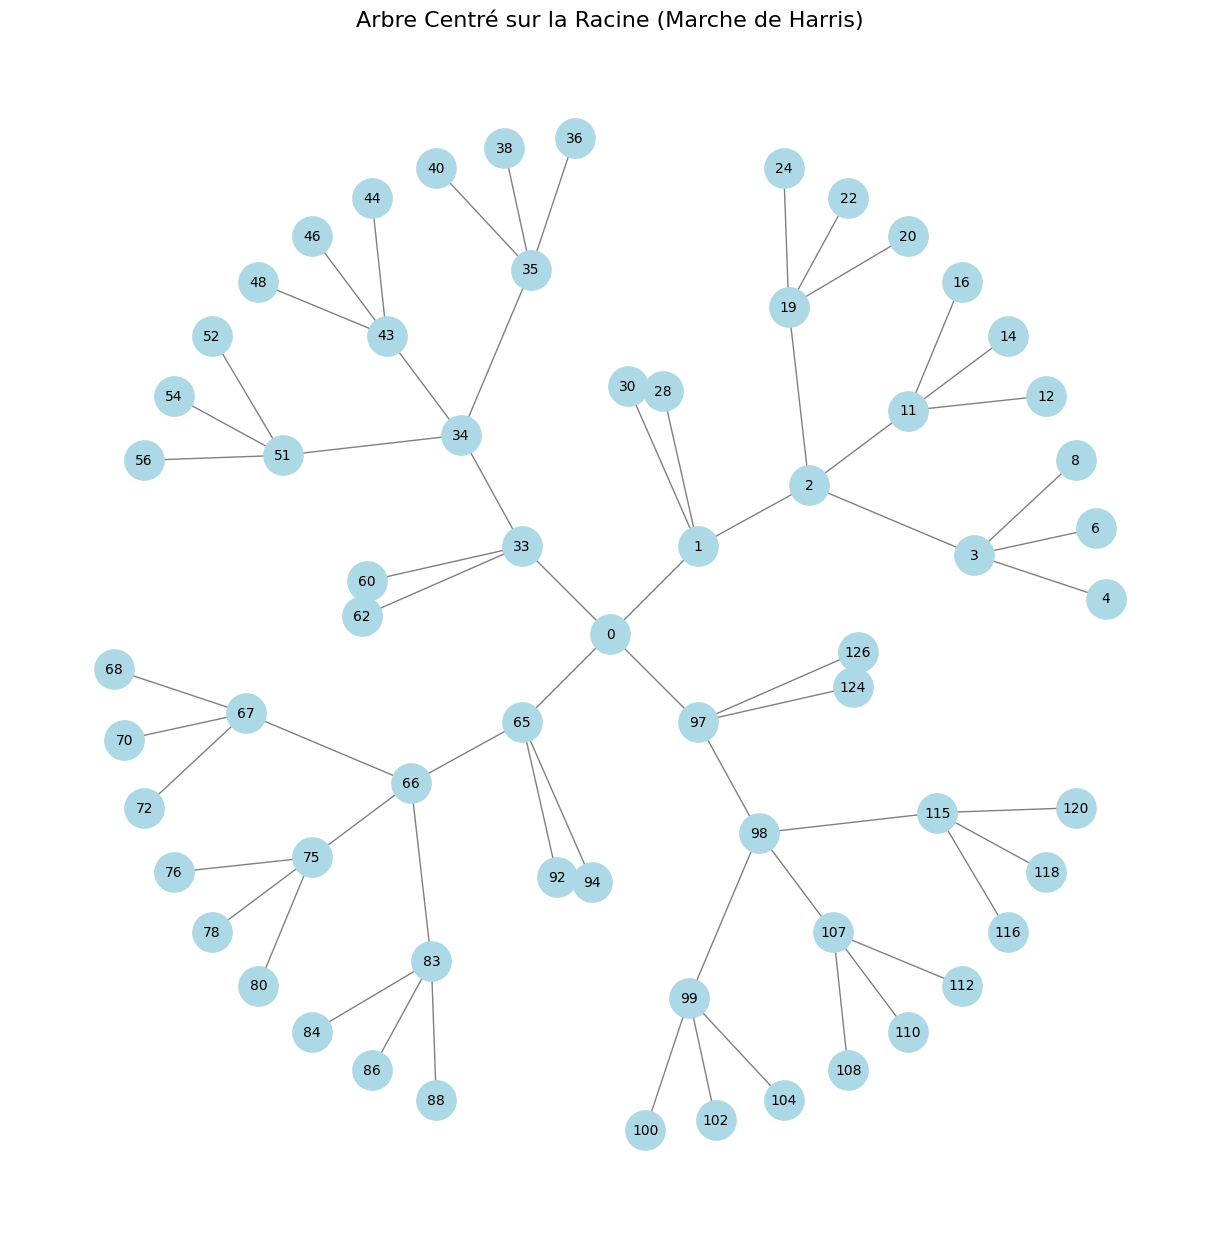

Pour m=5
motif de base: [0 1 0 1 0 1 0 1 0 1 0]


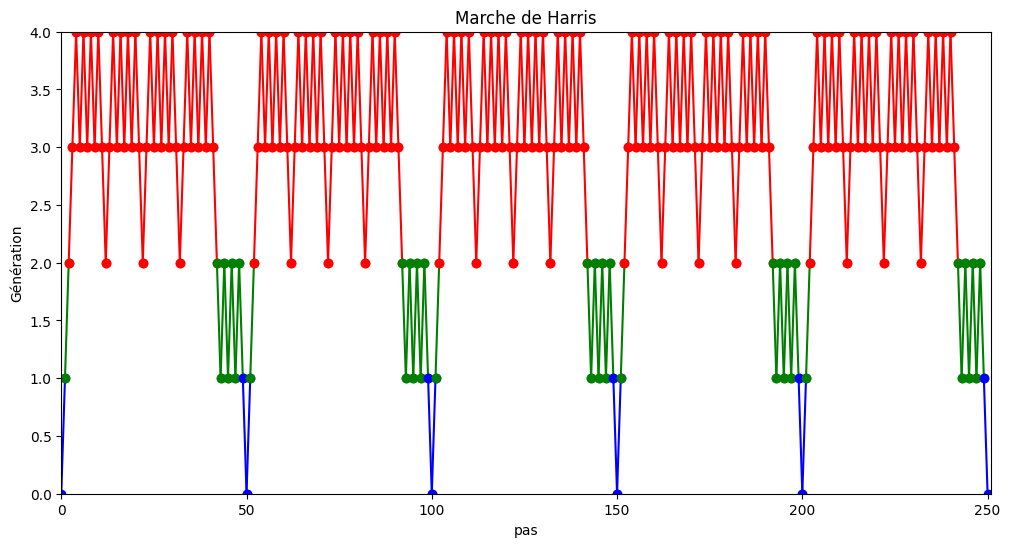

DiGraph with 126 nodes and 125 edges


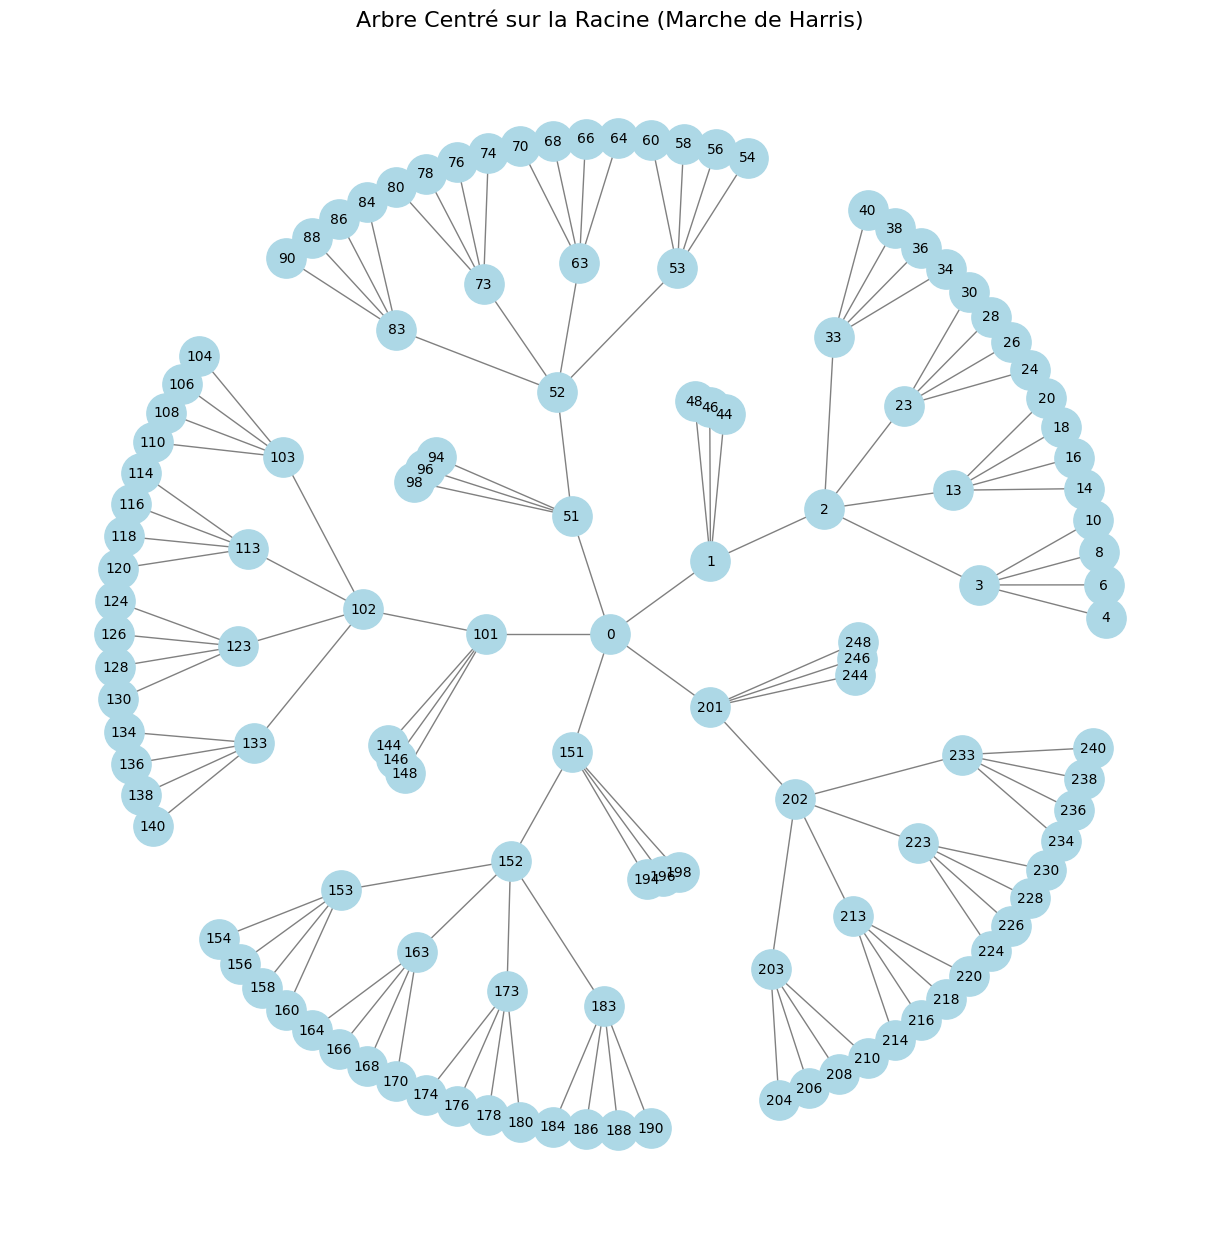

In [28]:
# Quel est l'influence du paramètre m sur l'arbre fractale ? (Sur la marche de Harris et l'arbre visualisé)

print("Pour m=3")
S = recurrence_transformation(2, 3, verbose=False)
visualisation_harris_walk(S)
tree, root = tree_build_from_harris_walk(S)
print(tree)
visualisation_tree(tree, root)

print("Pour m=4")
S = recurrence_transformation(2, 4, verbose=False)
visualisation_harris_walk(S)
tree, root = tree_build_from_harris_walk(S)
print(tree)
visualisation_tree(tree, root)

print("Pour m=5")
S = recurrence_transformation(2, 5, verbose=False)
visualisation_harris_walk(S)
tree, root = tree_build_from_harris_walk(S)
print(tree)
visualisation_tree(tree, root)


#### 2.2. Arbre Galton-Watson

In [9]:
def harris_walk_Galton_Watson(p, depth=10):
    """
    Génère une marche de Harris suivant une loi de Bernoulli de paramètre p.
    La marche s'arrête lorsque la position retourne à 0.

    :param p: Probabilité de succès (p).
    :return: Liste des positions de la marche de Harris.
    """
    # Initialisation de la position de départ
    X = [0]  # La marche commence à 0
    B = []

    while True:
        if X[-1] < depth:
            # Générer un pas basé sur la loi de Bernoulli
            step = 1 if random.random() < p else -1  # +1 pour succès, -1 pour échec
            B.append(step)

            # Ajouter le pas à la position actuelle
            new_position = X[-1] + step
            # print(new_position)
        else :
            # Ajouter le pas à la position actuelle
            new_position = X[-1] -1

        # Arrêter si la marche revient à 0
        if new_position >= 0 :
            X.append(new_position)
        else :
            break

        # Arrêter si la marche dépasse n étapes:

    return X, B


#### **Applications**

A l'aide de nos fonctions, nous pouvons visualiser 2 phénomènes:
* Quelle est l'influence du paramètre p dela loi géométrique? Sachant que plus p grandit, plus un noeud parent a de probabilité de chance d'avoir plusieurs enfants.

Remarque: Il s'agit d'un arbre aléatoire. Il est plus dur de voir l'influence. Mais ce qui est sûr, c'est qu'on a bien plus de chance d'atteindre la profondeur maximale de 4 quand on a p=0.8 que p=0.6.

Pour p=0.6
Marche de Harris : [0]
1


<ipython-input-17-f61483d1012d>:61: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,np.maximum(np.amax(S), y_max))


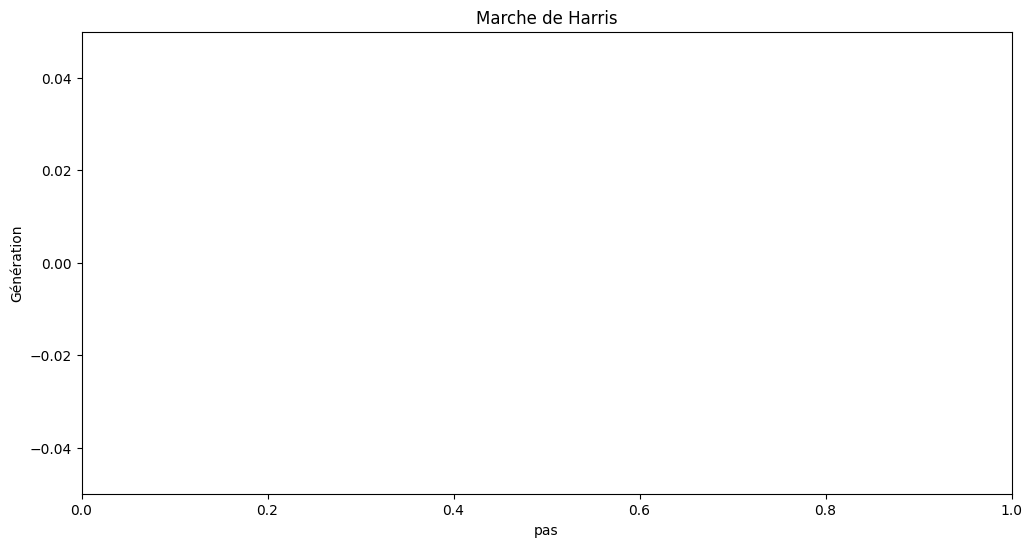

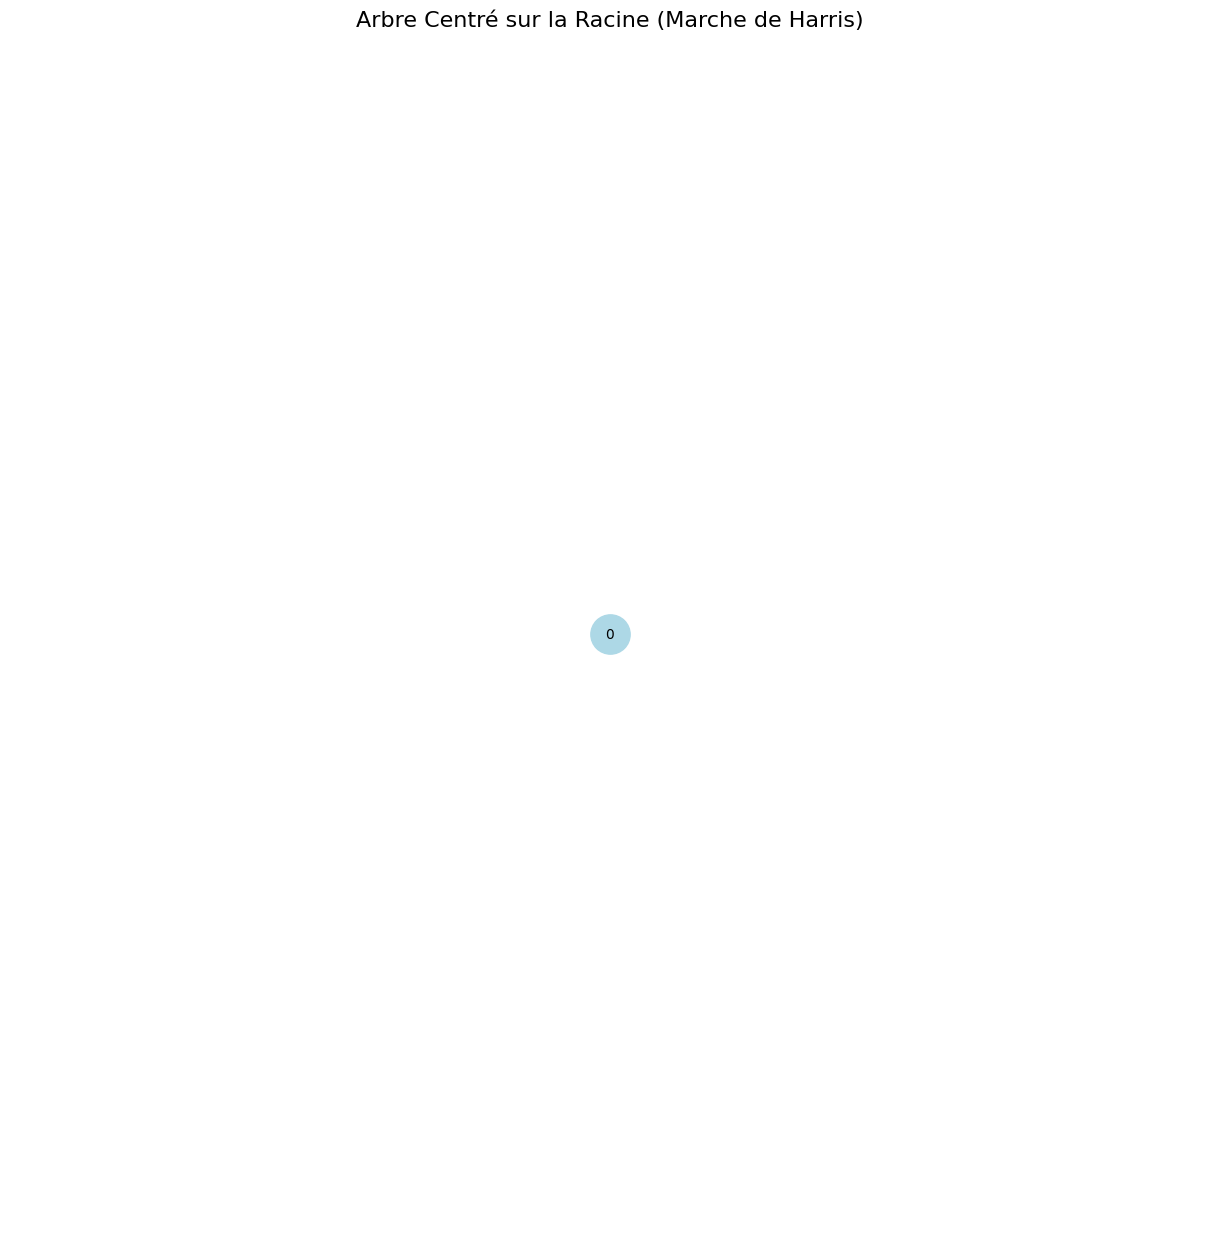

Pour p=0.7
Marche de Harris : [0, 1, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 0]
55


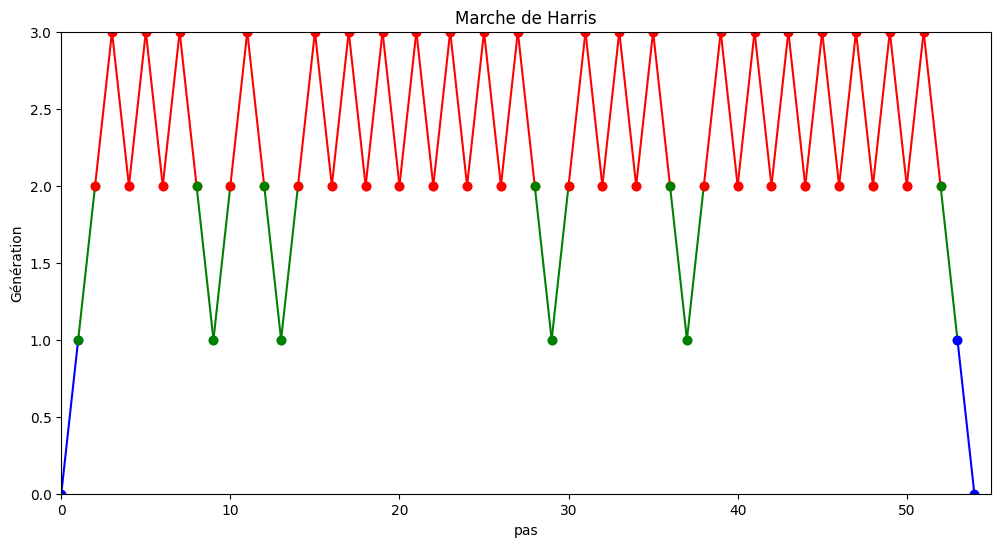

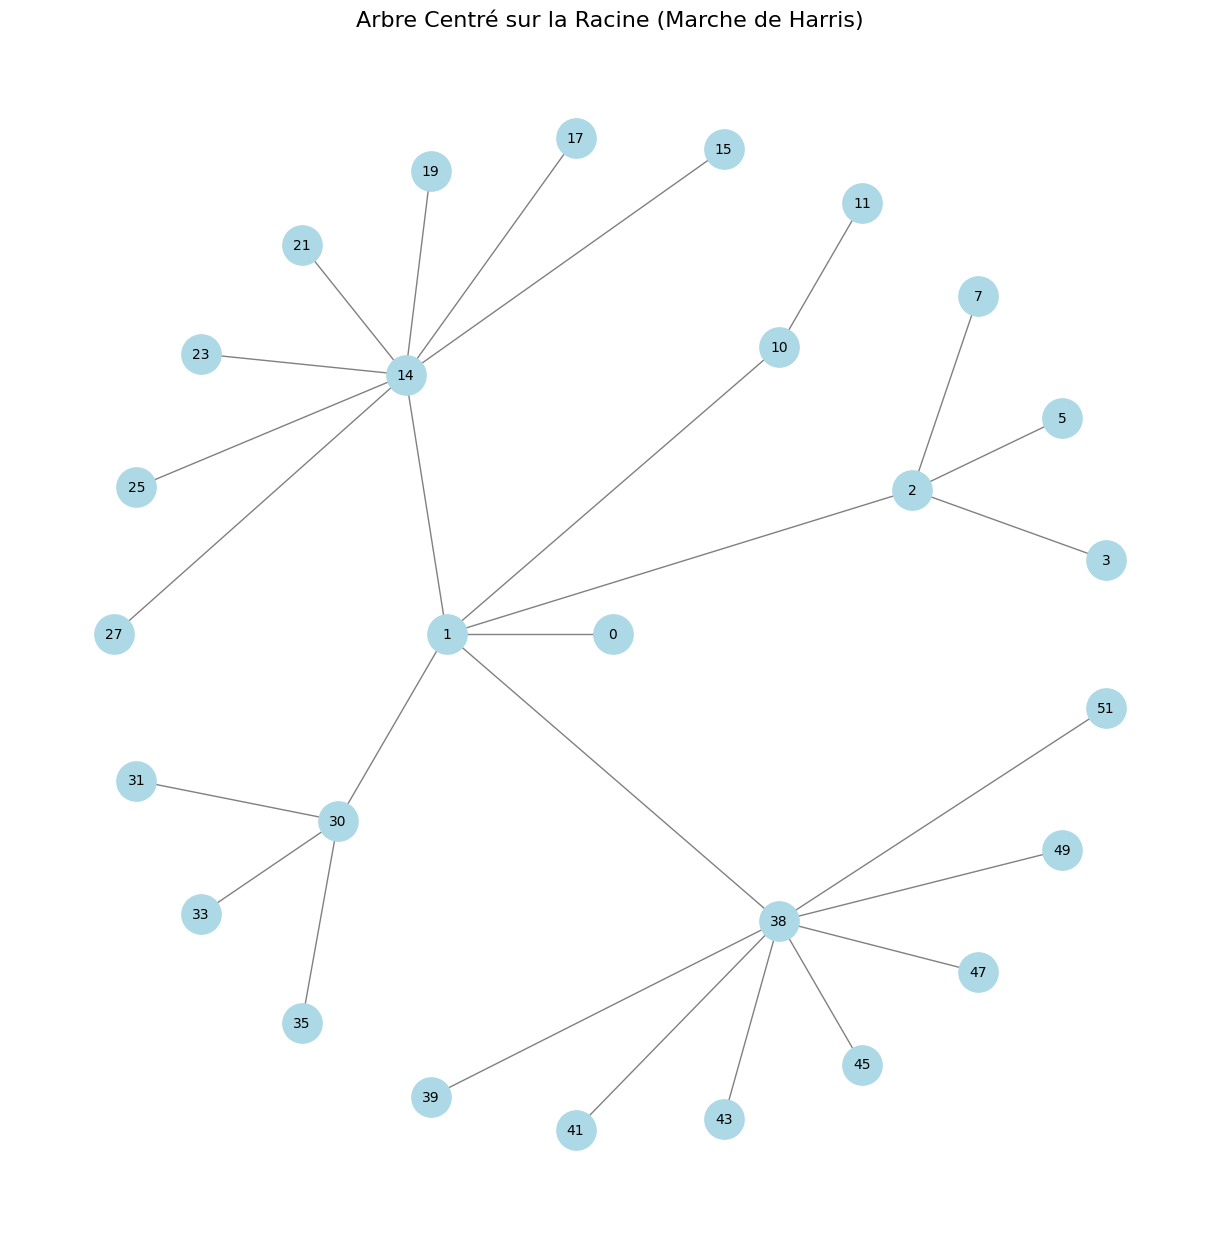

Pour p=0.8
Marche de Harris : [0, 1, 0, 1, 0]
5


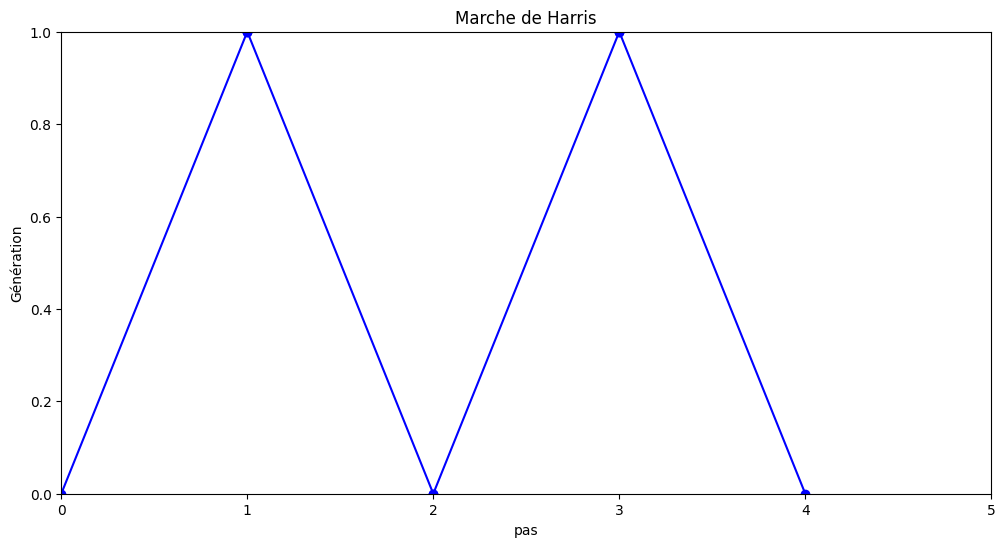

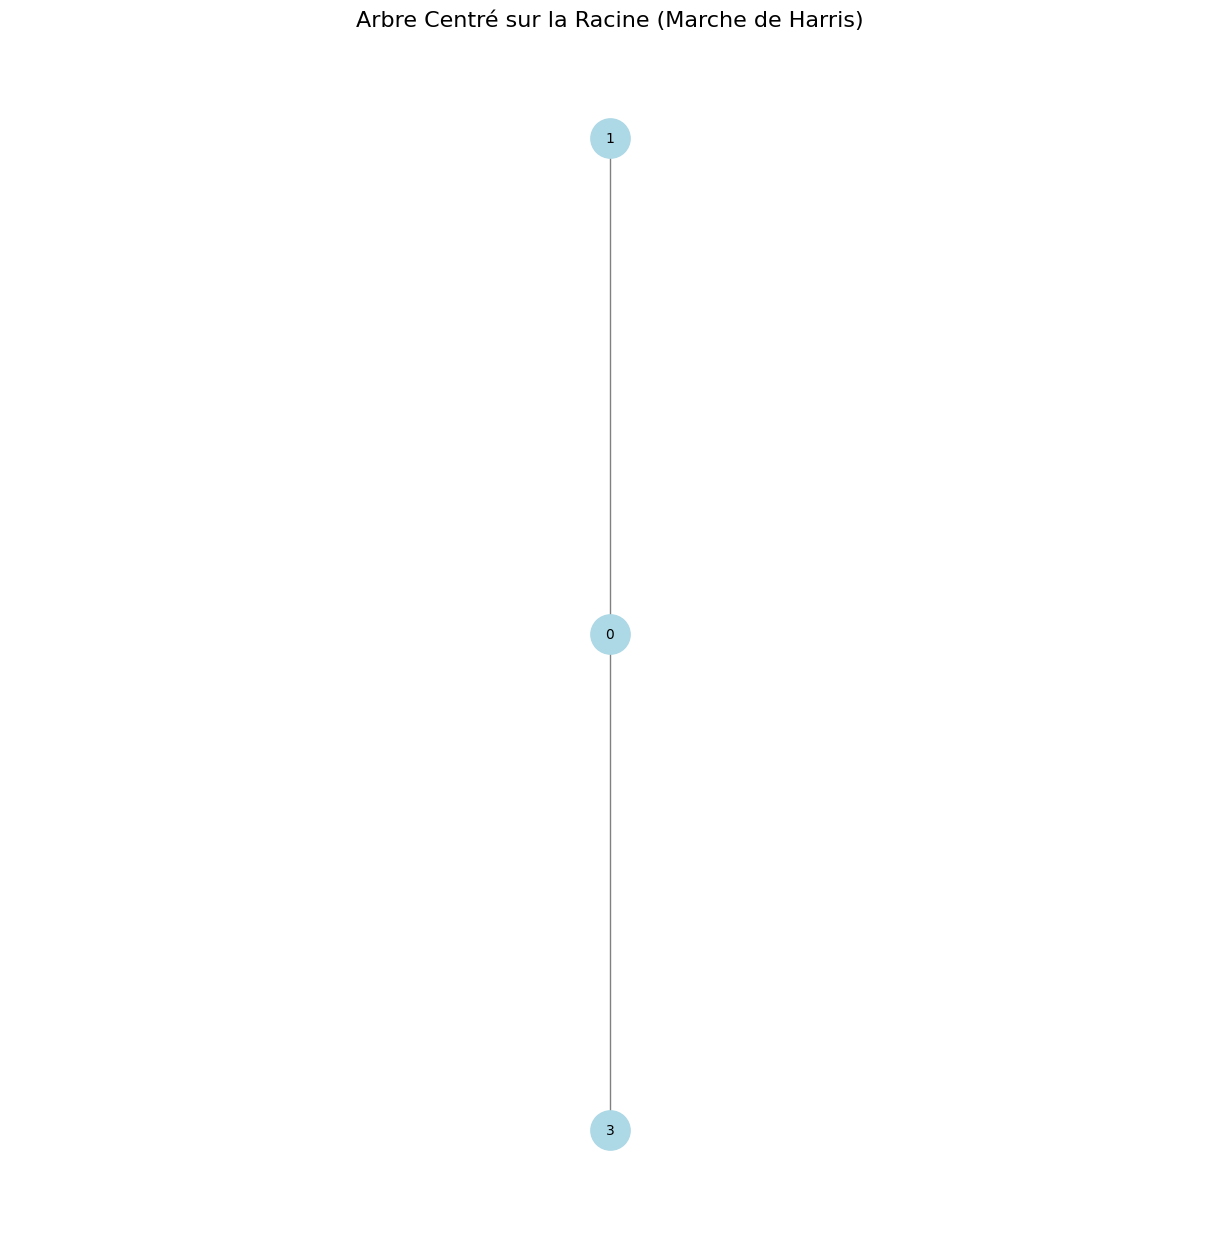

In [70]:
print("Pour p=0.6")
depth = 3
p = 0.6  # Probabilité de succès
X, B = harris_walk_Galton_Watson(p, depth)

# Affichage de la marche de Harris
print("Marche de Harris :", X)
print(len(X))
visualisation_harris_walk(X)

# Affichage de l'arbre
tree, root = tree_build_from_harris_walk(X)
visualisation_tree(tree, root)

print("Pour p=0.7")
depth = 3
p = 0.7  # Probabilité de succès
X, B = harris_walk_Galton_Watson(p, depth)

# Affichage de la marche de Harris
print("Marche de Harris :", X)
print(len(X))
visualisation_harris_walk(X)

# Affichage de l'arbre
tree, root = tree_build_from_harris_walk(X)
visualisation_tree(tree, root)

print("Pour p=0.8")
depth = 3
p = 0.8  # Probabilité de succès
X, B = harris_walk_Galton_Watson(p, depth)

# Affichage de la marche de Harris
print("Marche de Harris :", X)
print(len(X))
visualisation_harris_walk(X)

# Affichage de l'arbre
tree, root = tree_build_from_harris_walk(X)
visualisation_tree(tree, root)

### 3. Compresseurs - Mise en place

#### 3.1 Compresseur maison

In [43]:
############################################
# Etape 1 : Encode_n_fois et Encode_n_fois_recursive
############################################

def Encode_n_fois(signal):
    """
    Étape 1 du pipeline de compression.
    Cherche le motif répétitif `signal_bis` dans le signal binaire d'entrée,
    répétitif `n` fois consécutivement, et l'encode sous la forme :

        "<partie amont> 0 <code_binaire_de_n> <signal_bis> <partie aval>"

    Les parties non compressées sont conservées telles quelles.
    """
    def find_longest_repetition(signal):
        length = len(signal)
        best_start = 0
        best_subsignal = None
        best_n = 1

        for start in range(length):
            for part_length in range(1, (length - start) // 2 + 1):
                subsignal = signal[start:start + part_length]
                n = 0
                while signal[start + n * part_length:start + (n + 1) * part_length] == subsignal:
                    n += 1
                if n > 1:  # Au moins une répétition
                    # Condition supplémentaire : len(subsignal) > len(signal) / (n * 8)
                    if len(subsignal) > len(signal) / (n * 8):
                        if len(subsignal) * n > len(best_subsignal or "") * best_n:
                            best_start, best_subsignal, best_n = start, subsignal, n

        return best_start, best_subsignal, best_n

    start, signal_bis, n = find_longest_repetition(signal)
    if n == 1 or not signal_bis:
        return signal

    part_amont = signal[:start]
    part_aval = signal[start + len(signal_bis) * n:]
    compressed = f"{part_amont} 0 {bin(n)[2:]} {signal_bis} {part_aval}".strip()
    return compressed

def Encode_n_fois_recursive(signal):
    """
    Applique Encode_n_fois au signal jusqu'à ce que plus aucune compression ne soit possible.
    Retourne le signal final après épuisement des compressions possibles.
    """
    while True:
        compressed = Encode_n_fois(signal)
        if compressed == signal:
            break
        else:
            signal = compressed
    return signal

In [20]:
############################################
# Etape 2 : Encode (détection des duplicats normaux)
############################################

log2p = lambda x: int(ceil(log2(x)))
MAXPATTERNSIZE = 128		# max length of duplicates

def BackExplore(Str, split, Pattern):
    PatternLength = len(Pattern)
    MaxPast = 2 ** (PatternLength - log2p(1+PatternLength)) - 1 if PatternLength >=4 else 0
    if MaxPast > 0:
        Best = ' ' * PatternLength
        for shift in range(min(split, MaxPast)):
            if Str[split-shift-PatternLength:split-shift] == Pattern:
                Code = "%s %s" % (bin(shift)[2:], bin(PatternLength)[2:])
                if len(Code) < len(Best):
                    Best = Code
        if Best.strip():
            return Best
    return None

def Encode(Str):
    " detects duplicates and encodes the string accordingly "

    Best = (0, 0, ' ' * MAXPATTERNSIZE)
    for split in range(len(Str)):
        for PatternLength in range(MAXPATTERNSIZE, 2, -1):
            Pattern = Str[split:split+PatternLength]
            ActualPL = len(Pattern)
            BE = BackExplore(Str, split, Pattern)
            if BE:
                Gain = ActualPL - len(BE)
                if Gain > 1 and Gain > Best[1] - len(Best[2]):
                    Best = (split, ActualPL, BE)
    splt, pl, be = Best
    if be.strip():
        Start = Encode(Str[:splt])
        End = Encode(Str[splt+pl:])
        print('pattern %s of length %d is duplicated at location %d' % (Str[splt:splt+pl], pl, splt))
        return ('%s 1 %s %s' % (Start, be, End)).strip()
    return Str

In [21]:
############################################
# Etape 3 : Encode_mirror (détection des duplicats complémentaires)
############################################

def pattern_miroir_harris(pattern):
    """
    Transforme un motif en son symétrique selon la marche de Harris.
    Inverse l'ordre des bits, puis échange les 0 et les 1.

    :param pattern: str, un signal binaire représentant la marche (e.g., "1101").
    :return: str, le symétrique selon la marche de Harris.
    """
    # Étape 1 : Inverser l'ordre des bits
    reversed_pattern = pattern[::-1]
    # Étape 2 : Inverser les 0 et les 1
    miroir_pattern = ''.join('1' if bit == '0' else '0' for bit in reversed_pattern)
    return miroir_pattern

log2p = lambda x: int(ceil(log2(x)))
MAXPATTERNSIZE = 64		# max length of duplicates

def BackExploreComplement(Str, split, Pattern):
    PatternLength = len(Pattern)
    ComplementPattern = pattern_miroir_harris(Pattern)
    MaxPast = 2 ** (PatternLength - log2p(1+PatternLength)) - 1 if PatternLength >=4 else 0
    if MaxPast > 0:
        Best = ' ' * PatternLength
        for shift in range(min(split, MaxPast)):
            if Str[split-shift-PatternLength:split-shift] == ComplementPattern:
                Code = "%s %s" % (bin(shift)[2:], bin(PatternLength)[2:])
                if len(Code) < len(Best):
                    Best = Code
        if Best.strip():
            return Best
    return None

def Encode_mirror(Str):
    " detects complement duplicates and encodes the string accordingly "

    Best = (0, 0, ' ' * MAXPATTERNSIZE)
    for split in range(len(Str)):
        for PatternLength in range(MAXPATTERNSIZE, 2, -1):
            Pattern = Str[split:split+PatternLength]
            ActualPL = len(Pattern)
            BE = BackExploreComplement(Str, split, Pattern)
            if BE:
                Gain = ActualPL - len(BE)
                if Gain > 1 and Gain > Best[1] - len(Best[2]):
                    Best = (split, ActualPL, BE)
    splt, pl, be = Best
    if be.strip():
        Start = Encode_mirror(Str[:splt])
        End = Encode_mirror(Str[splt+pl:])
        print('pattern %s of length %d is duplicated mirror at location %d' % (Str[splt:splt+pl], pl, splt))
        return ('%s 00 %s %s' % (Start, be, End)).strip()
    return Str

In [22]:
############################################
# Pipeline complet
############################################

def compress_pipeline(signal):
    # Étape 1 : Répéter Encode_n_fois jusqu'à épuisement
    step1_result = Encode_n_fois_recursive(signal)

    # Étape 2 : Appliquer Encode pour détecter et encoder
    step2_result = Encode(step1_result)

    # Étape 3 : Appliquer Encode_mirror pour détecter et encoder les duplicats miroirs
    step3_result = Encode_mirror(step2_result)

    return len(step3_result)

#### 3.2 Compresseurs classiques zip, gzip, bzip2

In [2]:
def compress_with_zip(signal):
    """
    Compresse un signal binaire en utilisant le compresseur ZIP (zlib).
    Parameters:
        signal (str): Le signal binaire à compresser.
    Returns:
        int: Taille de la compression.
    """
    compressed = zlib.compress(signal.encode())
    return len(compressed)


def compress_with_gzip(signal):
    """
    Compresse un signal binaire en utilisant le compresseur GZIP.
    Parameters:
        signal (str): Le signal binaire à compresser.
    Returns:
        int: Taille de la compression.
    """
    out = io.BytesIO()
    with gzip.GzipFile(fileobj=out, mode="w") as f:
        f.write(signal.encode())
    return len(out.getvalue())

def compress_with_bzip2(signal):
    """
    Compresse un signal binaire en utilisant BZIP2.
    """
    compressed = bz2.compress(signal.encode())
    return len(compressed)



### 4. **Compression des marches de Harris binaires**


#### 4.0. Fonction pour passer d'une marche de Harris à une marche de Harris binaire

In [3]:
def harris_walk_to_binary(walk):
    """
    Convertit une marche de Harris en représentation binaire.
    """
    binary_encoding = []
    for i in range(len(walk) - 1):
        if walk[i+1] > walk[i]:
            binary_encoding.append(1)  # On monte
        else:
            binary_encoding.append(0)  # On descend

    binary_string = ''.join(str(bit) for bit in binary_encoding)
    return binary_string

#### 4.1. Arbre Mandelbrot/Vicsek


In [38]:
## Signal n°1 que l'on compresse

# Multiplicité m
m = 3

# Nombre d'itération k
k = 3

# Construction marche de Harris
X3_3 = recurrence_transformation(k, m, verbose=False)
X3_3 = harris_walk_to_binary(X3_3)
print("Marche Harris binaire:", X3_3)
print("Taille de la marche: ", len(X3_3))


motif de base: [0 1 0 1 0 1 0]
Marche Harris binaire: 111111110100110100010011110100110100010001001101000100111111110100110100010011110100110100010001001101000100111111110100110100010011110100110100010001001101000100
Taille de la marche:  162


In [40]:
## Signal n°2 que l'on compresse

# Multiplicité m
m = 4

# Nombre d'itération k
k = 5

# Construction marche de Harris
X4_5 = recurrence_transformation(k, m, verbose=False)
X4_5 = harris_walk_to_binary(X4_5)
print("Marche Harris binaire:", X4_5)
print("Taille de la marche: ", len(X4_5))

motif de base: [0 1 0 1 0 1 0 1 0]
Marche Harris binaire: 111111111111111111111111111111110101001101010011010100010100111101010011010100110101000101001111010100110101001101010001010001010011010100110101000101001111111101010011010100110101000101001111010100110101001101010001010011110101001101010011010100010100010100110101001101010001010011111111010100110101001101010001010011110101001101010011010100010100111101010011010100110101000101000101001101010011010100010100010100110101001101010001010011110101001101010011010100010100111101010011010100110101000101000101001101010011010100010100111111111111111101010011010100110101000101001111010100110101001101010001010011110101001101010011010100010100010100110101001101010001010011111111010100110101001101010001010011110101001101010011010100010100111101010011010100110101000101000101001101010011010100010100111111110101001101010011010100010100111101010011010100110101000101001111010100110101001101010001010001010011010100110101000101000101001101010011010100

In [4]:
# Fonction pour calculer le taux de compression
def calculate_compression_rate(original_length, compressed_length):
    return 1 - compressed_length / original_length

In [42]:


# Liste des compresseurs
compressors = {
    "Pipeline": compress_pipeline,
    "ZIP": compress_with_zip,
    "GZIP": compress_with_gzip,
    "BZIP2": compress_with_bzip2
}

# Collecte des résultats
results = []

for signal, name in [(X3_3, "X3_3"), (X4_5, "X4_5")]:
    original_length = len(signal)
    for compressor_name, compressor in compressors.items():
        try:
            compressed_length = compressor(signal)
            compression_rate = calculate_compression_rate(original_length, compressed_length)
            results.append({
                "Signal": name,
                "Compressor": compressor_name,
                "Original Length": original_length,
                "Compressed Length": int(compressed_length),
                "Compression Rate": round(compression_rate,2)
            })
        except Exception as e:
            results.append({
                "Signal": name,
                "Compressor": compressor_name,
                "Original Length": original_length,
                "Compressed Length": None,
                "Compression Rate": None,
                "Error": str(e)
            })

# Conversion en DataFrame
df_results = pd.DataFrame(results)
display(df_results)

pattern 11 0 10 0100 of length 12 is duplicated at location 62
pattern 01010011 of length 8 is duplicated at location 16
pattern  11111111 0 1 of length 13 is duplicated at location 27
pattern   0 10 0101001101010011010100010100 of length 35 is duplicated at location 80
pattern 011010100010100 of length 15 is duplicated at location 50
pattern   0 10 0101001101010011010100010100 of length 35 is duplicated at location 69
pattern  0 10  0 10 01010011010100110101000101001111  0 10 0101001101010 of length 64 is duplicated at location 118


,Signal,Compressor,Original Length,Compressed Length,Compression Rate
0,X3_3,Pipeline,162,73,0.55
1,X3_3,ZIP,162,25,0.85
2,X3_3,GZIP,162,37,0.77
3,X3_3,BZIP2,162,55,0.66
4,X4_5,Pipeline,8192,192,0.98
5,X4_5,ZIP,8192,129,0.98
6,X4_5,GZIP,8192,109,0.99
7,X4_5,BZIP2,8192,74,0.99


#### 4.2. Arbre de Galton Watson

In [30]:
## Signal 1

p = 0.7
depth = 5

S1, B = harris_walk_Galton_Watson(p, depth)
print("Marche de Harris:", S1)
S1 = harris_walk_to_binary(S1)
print("Marche de Harris binaire", S1)
print("Taille marche de Harris:", len(S1))

"""
On choisira toujours un arbre de Galton-Watson qui parviendra à aller jusqu'à la profondeur maximal souhaitée.
max(X) == depth
"""


Marche de Harris: [0, 1, 2, 1, 2, 3, 2, 3, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 3, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 3, 2, 3, 2, 3, 4, 5, 4, 5, 4, 3, 4, 3, 4, 3, 2, 1, 2, 3, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 3, 2, 3, 4, 5, 4, 3, 4, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 3, 2, 3, 4, 3, 2, 1, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 4, 3, 4, 5, 4, 3, 4, 5, 4, 5, 4, 3, 4, 3, 2, 1, 2, 3, 2, 3, 2, 1, 2, 3, 4, 3, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 4, 3, 4, 5, 4, 5, 4, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 4, 5, 4, 3, 2, 3, 2, 1, 2, 1, 2, 1, 0, 

"\nOn choisira toujours un arbre de Galton-Watson qui parviendra à aller jusqu'à la profondeur maximal souhaitée.\nmax(X) == depth \n"

In [25]:
## Signal 2

p = 0.8
depth = 5

S2, B = harris_walk_Galton_Watson(p, depth)
print("Marche de Harris:", S2)
S2 = harris_walk_to_binary(S2)
print("Marche de Harris binaire", S2)
print("Taille marche de Harris:", len(S2))

"""
On choisira toujours un arbre de Galton-Watson qui parviendra à aller jusqu'à la profondeur maximal souhaitée.
max(X) == depth
"""

Marche de Harris: [0, 1, 0, 1, 2, 1, 2, 1, 2, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 2, 1, 2, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 3, 4, 5, 4, 3, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 3, 4, 3, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 4, 5, 4, 3, 4, 

"\nOn choisira toujours un arbre de Galton-Watson qui parviendra à aller jusqu'à la profondeur maximal souhaitée.\nmax(X) == depth \n"

In [31]:
# Collecte des résultats
results = []

for signal, name in [(S1, "S1"), (S2, "S2")]:
    original_length = len(signal)
    for compressor_name, compressor in compressors.items():
        try:
            compressed_length = compressor(signal)
            compression_rate = calculate_compression_rate(original_length, compressed_length)
            results.append({
                "Signal": name,
                "Compressor": compressor_name,
                "Original Length": original_length,
                "Compressed Length": int(compressed_length),
                "Compression Rate": round(compression_rate,2)
            })
        except Exception as e:
            results.append({
                "Signal": name,
                "Compressor": compressor_name,
                "Original Length": original_length,
                "Compressed Length": None,
                "Compression Rate": None,
                "Error": str(e)
            })

# Conversion en DataFrame
df_results = pd.DataFrame(results)
display(df_results)

pattern 100110101010 of length 12 is duplicated at location 22
pattern 10101010100110101010 of length 20 is duplicated at location 38
pattern 11101010100 of length 11 is duplicated at location 25
pattern 0101000111 of length 10 is duplicated at location 29
pattern 001101001 of length 9 is duplicated at location 97
pattern 101010101010 of length 12 is duplicated at location 124
pattern 1010101001101010101010 of length 22 is duplicated at location 76
pattern 10100011101010 of length 14 is duplicated at location 50
pattern 1010101010 of length 10 is duplicated at location 14
pattern 101011001101010 of length 15 is duplicated at location 47
pattern 1011001101010 of length 13 is duplicated at location 33
pattern 1101010101001101001 of length 19 is duplicated at location 61
pattern 10101010101010101001 of length 20 is duplicated at location 162
pattern 101010001110101010100110 of length 24 is duplicated at location 106
pattern 110101010100110101010101010 of length 27 is duplicated at locatio

,Signal,Compressor,Original Length,Compressed Length,Compression Rate
0,S1,Pipeline,708,680,0.04
1,S1,ZIP,708,133,0.81
2,S1,GZIP,708,144,0.80
3,S1,BZIP2,708,141,0.80
4,S2,Pipeline,504,440,0.13
5,S2,ZIP,504,88,0.83
6,S2,GZIP,504,101,0.80
7,S2,BZIP2,504,88,0.83


**Commentaires:**
* Le compresseur que nous avons construit ne fonctionne pas sur une marche de Harris d'un arbre de Galton-Watson. Mais c'est bien normal étant donné qu'il a été conçu en observant les caractéristiques d'un arbre fractal de Mandelbrot/Viczek. Il se généralise donc mal sur d'autres signaux.
* L'arbre de Galton-Watson est un arbre aléatoire et pourtant nos résultats montre qu'il est aussi hautement compressible. En fait, c'est tout à fait normal, car en définissant une profondeur maximale d'arbre, on retire son aspect aléatoire. En effet, l'arbre va taper la profondeur maximale descendre et retaper la profondeur un très grand nombre de fois. Ce qui donne des marches de Harris avec un motif "01" qui se répète énormément de fois et qui donne donc des marches de Harris hautement compressible aussi.

**Conclusion:**

Nous n'essaierons pas de calculer la distance NCD des marches de Harris d'arbres de Galton-Watson avec un paramètre p différents. Ce biais ajouté par l'établissement d'une profondeur maximale nous empéchera d'avoir des résultats concluants.

### 5. **Clustering arbres fractales Mandelbrot/Vicsek via distance NCD**

### 5.1. Choix du bon compresseur


In [5]:
# Test des différents compresseurs

# Sélecteur de compresseur
def compress_with(compressor, signal):
    if compressor == "zlib":
        return compress_with_zip(signal)
    elif compressor == "gzip":
        return compress_with_gzip(signal)
    elif compressor == "bzip2":
        return compress_with_bzip2(signal)
    elif compressor == "maison":
        return compress_pipeline(signal)
    else:
        raise ValueError(f"Compresseur {compressor} non pris en charge.")

# Évaluation des compresseurs
def evaluate_compressor(compressor):
    results = {}

    # 1. Idempotence
    signal = "1010101010101010" * 10
    Z_x = compress_with(compressor, signal)
    Z_Z_x = compress_with(compressor, "1" * Z_x)
    results["idempotence"] = abs(Z_Z_x - Z_x) < 0.05 * Z_x  # Tolérance de 5%

    # 2. Symétrie approximative
    x = "1010101010" * 5
    y = "0101010101" * 5
    Z_xy = compress_with(compressor, x + y)
    Z_yx = compress_with(compressor, y + x)
    results["symétrie"] = abs(Z_xy - Z_yx) < 0.05 * max(Z_xy, Z_yx)  # Tolérance de 5%

    # 3. Détection des régularités
    regular_signal = "101010" * 100
    random_signal = "".join(random.choice("01") for _ in range(len(regular_signal)))
    Z_regular = compress_with(compressor, regular_signal)
    Z_random = compress_with(compressor, random_signal)
    results["détection_régularités"] = Z_regular < 0.5 * Z_random  # Attendu : compression significative

    # 4. Détection des dépendances entre chaînes
    shared_pattern = "10101" * 10
    x = shared_pattern + "11111" * 10
    y = shared_pattern + "00000" * 10
    Z_x = compress_with(compressor, x)
    Z_y = compress_with(compressor, y)
    Z_xy = compress_with(compressor, x + y)
    results["dépendances"] = Z_xy <= Z_x + Z_y

    # 5. Consistance pour différentes tailles
    small_signal = "101010" * 10
    large_signal = small_signal * 10
    Z_small = compress_with(compressor, small_signal)
    Z_large = compress_with(compressor, large_signal)
    results["consistance"] = abs(Z_large / Z_small - len(large_signal) / len(small_signal)) < 0.1

    # 6. Auto-concatenation
    signal = "1010101010" * 10 + "1000101010001010101"*10
    Z_x = compress_with(compressor, signal)
    Z_xx = compress_with(compressor, signal + signal)
    results["auto-concatenation"] = abs(Z_xx - Z_x) < 0.05 * Z_x  # Tolérance de 5%

    return results


In [36]:
compressors = ["zlib", "gzip", "bzip2","maison"]
for comp in compressors:
    print(f"Évaluation du compresseur : {comp}")
    results = evaluate_compressor(comp)
    for test, passed in results.items():
        print(f"  {test.capitalize()} : {'Passé' if passed else 'Échoué'}")

Évaluation du compresseur : zlib
  Idempotence : Échoué
  Symétrie : Passé
  Détection_régularités : Passé
  Dépendances : Passé
  Consistance : Échoué
  Auto-concatenation : Échoué
Évaluation du compresseur : gzip
  Idempotence : Échoué
  Symétrie : Passé
  Détection_régularités : Passé
  Dépendances : Passé
  Consistance : Échoué
  Auto-concatenation : Échoué
Évaluation du compresseur : bzip2
  Idempotence : Passé
  Symétrie : Passé
  Détection_régularités : Passé
  Dépendances : Passé
  Consistance : Échoué
  Auto-concatenation : Passé
Évaluation du compresseur : maison
pattern 0101111 of length 7 is duplicated at location 102
pattern 1001100001 of length 10 is duplicated at location 147
pattern 010101001 of length 9 is duplicated at location 11
pattern 1001011 of length 7 is duplicated at location 15
pattern 0110000 of length 7 is duplicated at location 44
pattern 01000011110 of length 11 is duplicated at location 158
pattern 00111011111 of length 11 is duplicated at location 22
pa

**Conclusion**:
On choisira donc le compresseur bzip2 pour faire du clustering car il réussit le plus de tests. On gardera aussi notre compresseur maison.

#### 5.2 Maturité / Immaturité d'un arbre fractale de Mandelbrot/Vicsek

On va définir ce terme de maturité sous le prisme de la compressibilité. Traçons la courbe du taux de compressibilité en fonction du nombre d'itération k.

motif de base: [0 1 0 1 0 1 0]
k=2, Taux de compression (bzip2): 0.1111, Taux de compression (maison): 0.4074
motif de base: [0 1 0 1 0 1 0]
pattern   11 0 10  of length 10 is duplicated at location 17
k=3, Taux de compression (bzip2): 0.6605, Taux de compression (maison): 0.6975
motif de base: [0 1 0 1 0 1 0]
pattern  0100110100010 of length 14 is duplicated at location 52
k=4, Taux de compression (bzip2): 0.8745, Taux de compression (maison): 0.8642
motif de base: [0 1 0 1 0 1 0]
pattern 01001101000100 of length 14 is duplicated at location 50
pattern 0100110100010 of length 13 is duplicated at location 64
k=5, Taux de compression (bzip2): 0.9520, Taux de compression (maison): 0.9287
motif de base: [0 1 0 1 0 1 0]
pattern 1111111 of length 7 is duplicated at location 18
pattern 11111111 0 10 of length 13 is duplicated at location 35
pattern 01001101000100 of length 14 is duplicated at location 19
pattern 01001101000100 of length 14 is duplicated at location 33
pattern  11111111 0 10 

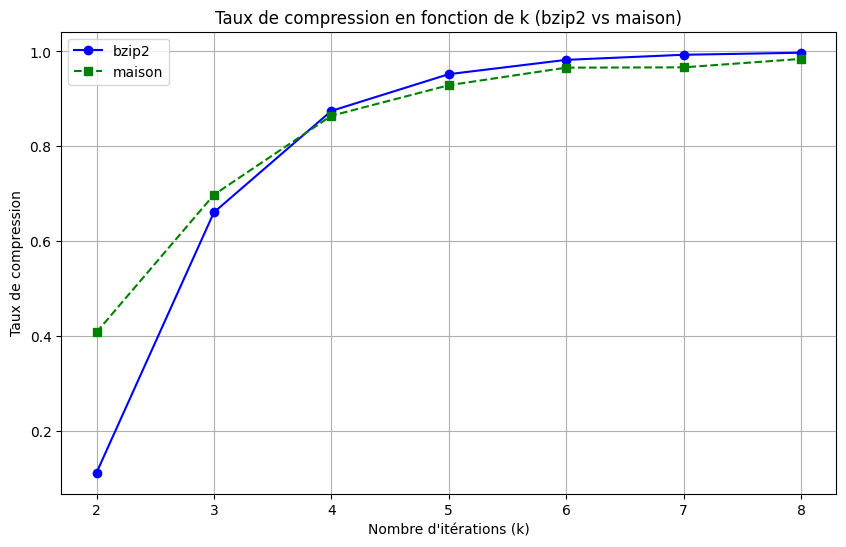

In [44]:
# Multiplicité m
m = 3

# Nombre d'itérations k (de 2 à 8)
k_values = range(2, 9)
compression_rates_bzip2 = []
compression_rates_maison = []

for k in k_values:
    # Construction de la marche de Harris
    S = recurrence_transformation(k, m, verbose=False)
    S_binary = harris_walk_to_binary(S)

    # Compression avec bzip2
    original_length = len(S_binary)
    compressed_length_bzip2 = compress_with_bzip2(S_binary)
    compression_rate_bzip2 = calculate_compression_rate(original_length, compressed_length_bzip2)
    compression_rates_bzip2.append(compression_rate_bzip2)

    # Compression avec gzip
    compressed_length_maison = compress_pipeline(S_binary)
    compression_rate_maison = calculate_compression_rate(original_length, compressed_length_maison)
    compression_rates_maison.append(compression_rate_maison)

    print(f"k={k}, Taux de compression (bzip2): {compression_rate_bzip2:.4f}, Taux de compression (maison): {compression_rate_maison:.4f}")

# Tracé des courbes
plt.figure(figsize=(10, 6))
plt.plot(k_values, compression_rates_bzip2, marker='o', linestyle='-', label="bzip2", color="blue")
plt.plot(k_values, compression_rates_maison, marker='s', linestyle='--', label="maison", color="green")
plt.title("Taux de compression en fonction de k (bzip2 vs maison)")
plt.xlabel("Nombre d'itérations (k)")
plt.ylabel("Taux de compression")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

#### 5.3 Distance NCD sur marche de Harris - clustering en fonction de la multiplicité m

#### Sur fractales immatures

On fait varier m de 3 à 5. Et k de 2 à 4. On pose Sm_k les marches de Harris binaires obtenues et on essaye de regrouper les fractales en fonction de leur multiplicité m en faisant une matrice des NCD pour le compresseur maison et le compresseur bzip2.

In [45]:
## Récupération des signaux

X_3 = []
for N in range(2,5):
    X3 = recurrence_transformation(N, 3)
    X_binary_3 = harris_walk_to_binary(X3)
    X_3.append(X_binary_3)

X_4 = []
for N in range(2,5):
    X4 = recurrence_transformation(N, 4)
    X_binary_4 = harris_walk_to_binary(X4)
    X_4.append(X_binary_4)

X_5 = []
for N in range(2,5):
    X5 = recurrence_transformation(N, 5)
    X_binary_5 = harris_walk_to_binary(X5)
    X_5.append(X_binary_5)


motif de base: [0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0]


In [6]:
## Fonction qui calcule la NCD

def NCD_calculator(signal_1, signal_2, compressor):
    """
    Calcule la distance NCD entre deux signaux binaires.

    Parameters:
        signal_1 (str): Premier signal binaire.
        signal_2 (str): Deuxième signal binaire.

    Returns:
        float: Distance NCD entre signal_1 et signal_2.
    """
    # Calculer les compressions individuelles
    Z_signal_1 = compressor(signal_1)
    Z_signal_2 = compressor(signal_2)

    # Calculer la compression de la concaténation
    concatenated_signal = signal_1 + signal_2
    Z_concat = compressor(concatenated_signal)

    # Calculer la NCD
    NCD = (Z_concat - min(Z_signal_1, Z_signal_2)) / max(Z_signal_1, Z_signal_2)
    return NCD

pattern   11 0 10  of length 10 is duplicated at location 17
pattern 0 10 11 of length 7 is duplicated at location 8
pattern  01001101000100 of length 15 is duplicated at location 77
pattern  0100110100010 of length 14 is duplicated at location 52
pattern 01001101000100 of length 14 is duplicated at location 34
pattern 111101001101000100  of length 19 is duplicated at location 90
pattern 01001101000100 of length 14 is duplicated at location 109
pattern 1101000 of length 7 is duplicated mirror at location 13
pattern  0 10 010100 of length 12 is duplicated at location 53
pattern   0 10 010100 of length 13 is duplicated at location 67
pattern  0 10 010100 of length 12 is duplicated at location 44
pattern 0 11110100110100 of length 16 is duplicated at location 22
pattern 1101000 of length 7 is duplicated mirror at location 13
pattern 01010011 of length 8 is duplicated at location 10
pattern  1111 0 1 of length 9 is duplicated at location 23
pattern 01010011 of length 8 is duplicated at loc

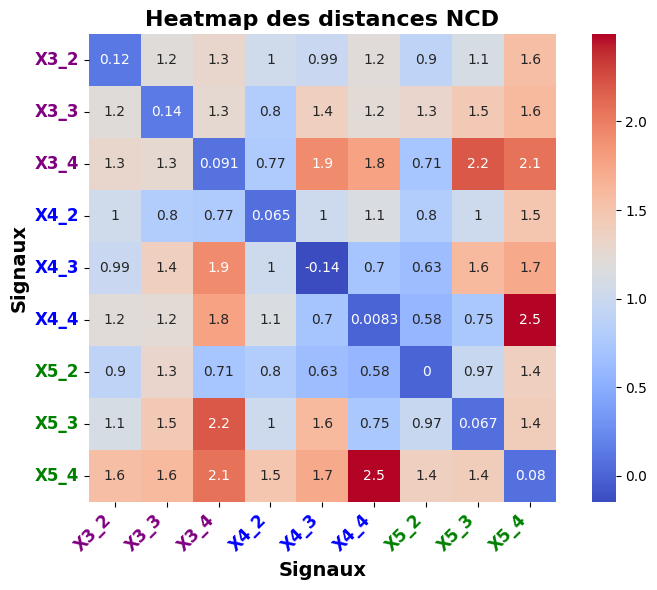

In [47]:
## Compresseur maison - distance NCD


# Créez une liste combinée des signaux
all_signals = X_3 + X_4 + X_5
signal_labels = [f"X3_{i+2}" for i in range(len(X_3))] + \
                [f"X4_{i+2}" for i in range(len(X_4))] + \
                [f"X5_{i+2}" for i in range(len(X_5))]


# Initialisation du DataFrame pour stocker les distances NCD
df_ncd = pd.DataFrame(index=signal_labels, columns=signal_labels)

# Convertir toutes les valeurs en float
df_ncd = df_ncd.apply(pd.to_numeric, errors='coerce')

# Calcul des distances NCD
for i, sig1 in enumerate(all_signals):
    for j, sig2 in enumerate(all_signals):
        if i <= j:  # Calculer une seule fois par paire
            ncd_value = NCD_calculator(sig1, sig2, compress_pipeline)
            df_ncd.iloc[i, j] = ncd_value
            df_ncd.iloc[j, i] = ncd_value  # Symétrique




# Définir les couleurs pour les étiquettes
label_colors = {
    "X3": "purple",
    "X4": "blue",
    "X5": "green"
}

# Mapper les couleurs en fonction des étiquettes
x_colors = [label_colors[label[:2]] for label in signal_labels]
y_colors = [label_colors[label[:2]] for label in signal_labels]

# Créer une heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df_ncd, annot=True, cmap="coolwarm", cbar=True, square=True)

# Ajouter des couleurs, une taille plus grande et un style gras aux étiquettes des axes
ax.set_xticklabels(signal_labels, rotation=45, horizontalalignment='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(signal_labels, rotation=0, fontsize=12, fontweight='bold')

# Colorer les étiquettes des axes
for tick_label, color in zip(ax.get_xticklabels(), x_colors):
    tick_label.set_color(color)

for tick_label, color in zip(ax.get_yticklabels(), y_colors):
    tick_label.set_color(color)

plt.title("Heatmap des distances NCD", fontsize=16, fontweight='bold')
plt.xlabel("Signaux", fontsize=14, fontweight='bold')
plt.ylabel("Signaux", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

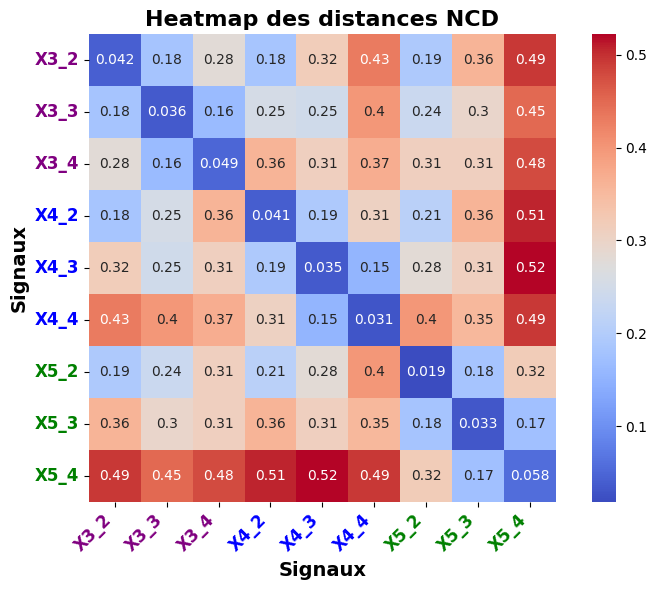

In [48]:
## Compresseur bzip2 - distance NCD


# Créez une liste combinée des signaux
all_signals = X_3 + X_4 + X_5
signal_labels = [f"X3_{i+2}" for i in range(len(X_3))] + \
                [f"X4_{i+2}" for i in range(len(X_4))] + \
                [f"X5_{i+2}" for i in range(len(X_5))]


# Initialisation du DataFrame pour stocker les distances NCD
df_ncd = pd.DataFrame(index=signal_labels, columns=signal_labels)

# Convertir toutes les valeurs en float
df_ncd = df_ncd.apply(pd.to_numeric, errors='coerce')

# Calcul des distances NCD
for i, sig1 in enumerate(all_signals):
    for j, sig2 in enumerate(all_signals):
        if i <= j:  # Calculer une seule fois par paire
            ncd_value = NCD_calculator(sig1, sig2, compress_with_bzip2)
            df_ncd.iloc[i, j] = ncd_value
            df_ncd.iloc[j, i] = ncd_value  # Symétrique




# Définir les couleurs pour les étiquettes
label_colors = {
    "X3": "purple",
    "X4": "blue",
    "X5": "green"
}

# Mapper les couleurs en fonction des étiquettes
x_colors = [label_colors[label[:2]] for label in signal_labels]
y_colors = [label_colors[label[:2]] for label in signal_labels]

# Créer une heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df_ncd, annot=True, cmap="coolwarm", cbar=True, square=True)

# Ajouter des couleurs, une taille plus grande et un style gras aux étiquettes des axes
ax.set_xticklabels(signal_labels, rotation=45, horizontalalignment='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(signal_labels, rotation=0, fontsize=12, fontweight='bold')

# Colorer les étiquettes des axes
for tick_label, color in zip(ax.get_xticklabels(), x_colors):
    tick_label.set_color(color)

for tick_label, color in zip(ax.get_yticklabels(), y_colors):
    tick_label.set_color(color)

plt.title("Heatmap des distances NCD", fontsize=16, fontweight='bold')
plt.xlabel("Signaux", fontsize=14, fontweight='bold')
plt.ylabel("Signaux", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Sur fractales matures

Pour des raisons de temps de calcul, nous n'utiliserons que le compresseur bzip2. On fait varier m de 3 à 7.

In [13]:
## Récupération des signaux

X_3 = []
for N in range(6,9):
    X3 = recurrence_transformation(N, 3)
    X_binary_3 = harris_walk_to_binary(X3)
    X_3.append(X_binary_3)

X_4 = []
for N in range(6,9):
    X4 = recurrence_transformation(N, 4)
    X_binary_4 = harris_walk_to_binary(X4)
    X_4.append(X_binary_4)

X_5 = []
for N in range(6,9):
    X5 = recurrence_transformation(N, 5)
    X_binary_5 = harris_walk_to_binary(X5)
    X_5.append(X_binary_5)

X_6 = []
for N in range(6,9):
    X6 = recurrence_transformation(N, 6)
    X_binary_6 = harris_walk_to_binary(X6)
    X_6.append(X_binary_6)

X_7 = []
for N in range(6,9):
    X7 = recurrence_transformation(N, 7)
    X_binary_7 = harris_walk_to_binary(X7)
    X_7.append(X_binary_7)

motif de base: [0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
motif de base: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


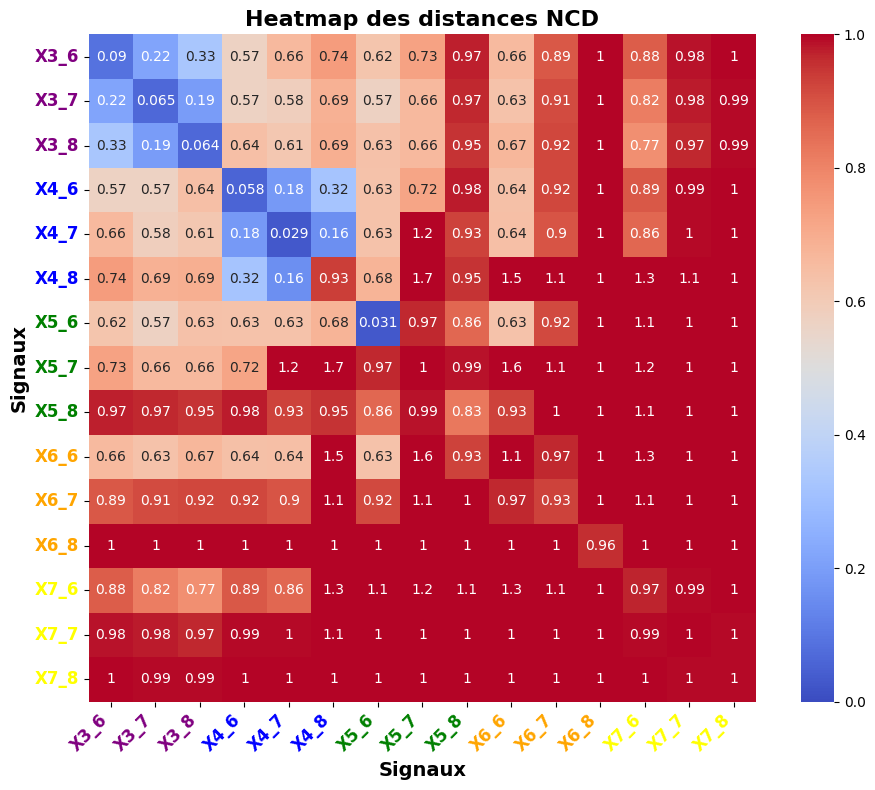

In [18]:
# For m in [3,4,5,6,7]

# Créez une liste combinée des signaux
all_signals = X_3 + X_4 + X_5 + X_6 + X_7
signal_labels = [f"X3_{i+6}" for i in range(len(X_3))] + \
                [f"X4_{i+6}" for i in range(len(X_4))] + \
                [f"X5_{i+6}" for i in range(len(X_5))] + \
                [f"X6_{i+6}" for i in range(len(X_6))] + \
                [f"X7_{i+6}" for i in range(len(X_7))]


# Initialisation du DataFrame pour stocker les distances NCD
df_ncd = pd.DataFrame(index=signal_labels, columns=signal_labels)

# Convertir toutes les valeurs en float
df_ncd = df_ncd.apply(pd.to_numeric, errors='coerce')

# Calcul des distances NCD
for i, sig1 in enumerate(all_signals):
    for j, sig2 in enumerate(all_signals):
        if i <= j:  # Calculer une seule fois par paire
            ncd_value = NCD_calculator(sig1, sig2, compress_with_bzip2)
            df_ncd.iloc[i, j] = ncd_value
            df_ncd.iloc[j, i] = ncd_value  # Symétrique




# Define colors for axis labels
label_colors = {
    "X3": "purple",
    "X4": "blue",
    "X5": "green",
    "X6": "orange",
    "X7": "yellow"
}

# Map colors based on labels
x_colors = [label_colors[label[:2]] for label in signal_labels]
y_colors = [label_colors[label[:2]] for label in signal_labels]

# Create a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_ncd,  # Keep original values
                 annot=True, cmap="coolwarm", cbar=True, square=True, vmin=0, vmax=1)

# Add colors and bold styling to axis labels
ax.set_xticklabels(signal_labels, rotation=45, horizontalalignment='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(signal_labels, rotation=0, fontsize=12, fontweight='bold')

# Color the axis labels
for tick_label, color in zip(ax.get_xticklabels(), x_colors):
    tick_label.set_color(color)

for tick_label, color in zip(ax.get_yticklabels(), y_colors):
    tick_label.set_color(color)

plt.title("Heatmap des distances NCD", fontsize=16, fontweight='bold')
plt.xlabel("Signaux", fontsize=14, fontweight='bold')
plt.ylabel("Signaux", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [15]:
# Créez une liste combinée des signaux
all_signals = X_3 + X_4 + X_5 + X_6 + X_7
signal_labels = [f"X3_{i+6}" for i in range(len(X_3))] + \
                [f"X4_{i+6}" for i in range(len(X_4))] + \
                [f"X5_{i+6}" for i in range(len(X_5))] + \
                [f"X6_{i+6}" for i in range(len(X_6))] + \
                [f"X7_{i+6}" for i in range(len(X_7))]

# Associer chaque label à la taille du signal
all_signals_with_labels = [(label, len(signal)) for label, signal in zip(signal_labels, all_signals)]

# Afficher les tuples (label, taille)
for label, size in all_signals_with_labels:
    print(f"{label}: {size}")


X3_6: 4374
X3_7: 13122
X3_8: 39366
X4_6: 32768
X4_7: 131072
X4_8: 524288
X5_6: 156250
X5_7: 781250
X5_8: 3906250
X6_6: 559872
X6_7: 3359232
X6_8: 20155392
X7_6: 1647086
X7_7: 11529602
X7_8: 80707214


In [16]:
# Trier les signaux par taille, du plus petit au plus grand
sorted_signals_with_labels = sorted(all_signals_with_labels, key=lambda x: x[1])

# Afficher les signaux triés
for label, size in sorted_signals_with_labels:
    print(f"{label}: {size}")


X3_6: 4374
X3_7: 13122
X4_6: 32768
X3_8: 39366
X4_7: 131072
X5_6: 156250
X4_8: 524288
X6_6: 559872
X5_7: 781250
X7_6: 1647086
X6_7: 3359232
X5_8: 3906250
X7_7: 11529602
X6_8: 20155392
X7_8: 80707214


In [20]:
import bz2
import pandas as pd

# Fonction pour calculer le taux de compression
def calculate_compression_rate(original_length, compressed_length):
    return 1 - compressed_length / original_length

# Fonction pour compresser un signal avec BZIP2
def compress_with_bzip2(signal):
    compressed = bz2.compress(signal.encode())
    return len(compressed)

# Liste des signaux triés par taille
sorted_signals_with_labels = sorted(all_signals_with_labels, key=lambda x: x[1])

# Calcul des tailles compressées et des taux de compression
data = []
for label, size in sorted_signals_with_labels:
    compressed_length = compress_with_bzip2(all_signals[signal_labels.index(label)])
    compression_rate = calculate_compression_rate(size, compressed_length)
    data.append((label, size, compressed_length, compression_rate))

# Création du DataFrame
df_signals = pd.DataFrame(data, columns=["Label", "Original Length", "Compressed Length", "Compression Rate"])

# Affichage du DataFrame
print(df_signals)


   Label  Original Length  Compressed Length  Compression Rate
0   X3_6             4374                 78          0.982167
1   X3_7            13122                 93          0.992913
2   X4_6            32768                 86          0.997375
3   X3_8            39366                109          0.997231
4   X4_7           131072                103          0.999214
5   X5_6           156250                 98          0.999373
6   X4_8           524288                121          0.999769
7   X6_6           559872                100          0.999821
8   X5_7           781250                115          0.999853
9   X7_6          1647086                212          0.999871
10  X6_7          3359232                453          0.999865
11  X5_8          3906250                593          0.999848
12  X7_7         11529602               1365          0.999882
13  X6_8         20155392               2510          0.999875
14  X7_8         80707214               9451          0

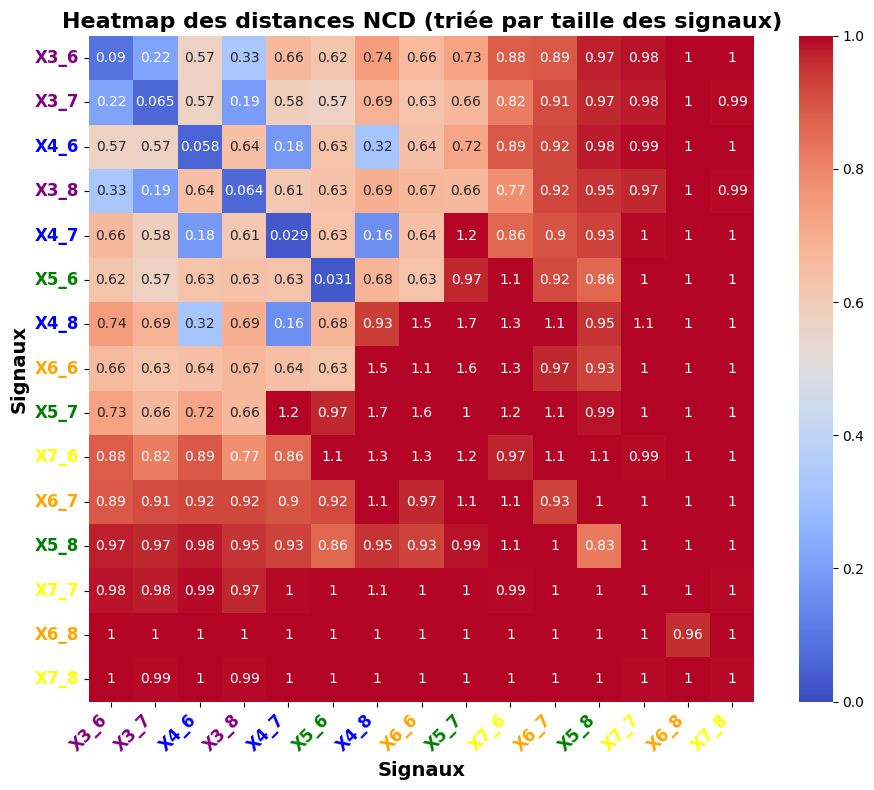

In [19]:
# Trier les signaux par taille et réorganiser leurs étiquettes
sorted_signals_with_labels = sorted(zip(signal_labels, all_signals), key=lambda x: len(x[1]))

# Extraire les étiquettes triées et les signaux triés
sorted_labels = [label for label, _ in sorted_signals_with_labels]
sorted_signals = [signal for _, signal in sorted_signals_with_labels]

# Réorganiser le DataFrame des distances NCD
df_ncd_sorted = df_ncd.loc[sorted_labels, sorted_labels]

# Mettre à jour les couleurs des étiquettes
x_colors_sorted = [label_colors[label[:2]] for label in sorted_labels]
y_colors_sorted = [label_colors[label[:2]] for label in sorted_labels]

# Créer une heatmap avec les signaux triés
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_ncd_sorted,  # Utiliser le DataFrame trié
                 annot=True, cmap="coolwarm", cbar=True, square=True, vmin=0, vmax=1)

# Mettre à jour les étiquettes des axes avec les labels triés
ax.set_xticklabels(sorted_labels, rotation=45, horizontalalignment='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(sorted_labels, rotation=0, fontsize=12, fontweight='bold')

# Colorer les étiquettes des axes
for tick_label, color in zip(ax.get_xticklabels(), x_colors_sorted):
    tick_label.set_color(color)

for tick_label, color in zip(ax.get_yticklabels(), y_colors_sorted):
    tick_label.set_color(color)

plt.title("Heatmap des distances NCD (triée par taille des signaux)", fontsize=16, fontweight='bold')
plt.xlabel("Signaux", fontsize=14, fontweight='bold')
plt.ylabel("Signaux", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()